# 0. Introduction

In this notebook, I will go through my solution and analysis of the [Kaggle Titanic survival prediction competition](https://www.kaggle.com/c/titanic/overview). The aim of this competition is simple, given what we know about a passenger aboard the Titanic, can we predict whether or not this passenger has survived? In other words, we want to train a machine learning model to learn the relationship between passenger features and their survival outcome and subsequently make survival predictions on passenger data that our model has not seen before.

This is a classic beginner's project suited for anyone who is looking to gain some hands-on experience with data science and machine learning. I hope you will find some value out of this notebook.

I drew inspirations from the following notebooks in the making of this notebook:
- [Titanic Data Science Solutions](https://www.kaggle.com/startupsci/titanic-data-science-solutions) by [Manav Sehgal](https://www.kaggle.com/startupsci)
- [Titanic Top 4% With Emsemble Modelling](https://www.kaggle.com/yassineghouzam/titanic-top-4-with-ensemble-modeling) by [Yassin Ghouzam](https://www.kaggle.com/yassineghouzam)
    
Kaggle competitions comprise of a minimum of 3 datasets that you can find and download from the competition webpage. The three datasets are:

1. Training set
2. Test set 
3. Sample submission

## Training set
This is the dataset that you will be working on predominantly. You will perform manipulation and analysis on this dataset to extract insights as well as build a predictive model. The goal here is to determine and create features that will help us predict the outcome of our data. There are two types of problems in machine learning and they are classfication and regression problems. Titanic is an example of a classification problem where the outcome is categorical. In other words, our model needs to be able to predict and classify outcomes as either one of two categories, survived or did not survive the titanic.

## Test set
Once our model has been built, we need to make sure that it does not merely fit our training set well but also able to make predictions on out-of-samples data, that is data our model has not been trained on. We will use the testing set as inputs to the model that we have built and make predictions based on those inputs. This is where you will be assessed in the competition i.e. how accurate is your model at predicting new observations. It is also important to note that every competition has different metrics in which they assess model accuracy and you can find this information under the evaluation tab in the overview section of the competition page. For this competition, the evaluation metric is simply the percentage of passengers that are correctly predicted by our model.

## Sample submission
This is the format in which you want to submit your final solution. Pay attention to the column headings and shape of the sample submission to get a better understanding on how you should structure your final dataframe for submission.

# 1. Import libraries

Here I will import the libraries that I will be using in my notebook. Libraries are essentially extensions to Python that consist of functions that are handy to have when we are performing our analysis. 

In [3]:
# Data wrangling
import pandas as pd
import numpy as np
import missingno
from collections import Counter

# Data visualisation
import seaborn as sns
import matplotlib.pyplot as plt

# Machine learning models
from sklearn.linear_model import LogisticRegression, Perceptron, SGDClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier

# Model evaluation
from sklearn.model_selection import cross_val_score

# Hyperparameter tuning
from sklearn.model_selection import GridSearchCV

# Remove warnings
import warnings
warnings.filterwarnings('ignore')

# 2. Import and read data

Now import and read the 3 datasets as outlined in the introduction.

In [4]:
test = pd.read_csv('../data/raw/test.csv')
train = pd.read_csv('../data/raw/train.csv')
ss = pd.read_csv('../data/raw/gender_submission.csv')

Let's have a look at the datasets.

In [5]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [7]:
print("Training set shape: ", train.shape)
print("Test set shape: ", test.shape)

Training set shape:  (891, 12)
Test set shape:  (418, 11)


Note that the test set has one column less than training set, the Survived column. This is because Survived is our response variable, or sometimes called a target variable. Our job is to analyse the data in the training set and predict the survival of the passengers in the test set.

What about sample submission?

In [8]:
ss.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [9]:
ss.shape

(418, 2)

So, our final dataframe that is to be submitted should look something like this, 418 rows and 2 columns, one for PassengerId and one for Survived.

# 3. Data description

Here I will outline the definitions of the columns in the titanic dataset. You can find this information under the [data](https://www.kaggle.com/c/titanic/data) tab of the competition page.

- Survived: 0 = Did not survive, 1 = Survived

- Pclass: Ticket class where 1 = First class, 2 = Second class, 3 = Third class. This can also be seen as a proxy for socio-economic status.

- Sex: Male or female

- Age: Age in years, fractional if less than 1

- SibSp: Number of siblings or spouses aboard the titanic

- Parch: Number of parents or children aboard the titanic

- Ticket: Passenger ticket number

- Fare: Passenger fare

- Cabin: Cabin number

- Embarked: Point of embarkation where C = Cherbourg, Q = Queenstown, S = Southampton

# 4. Exploratory Data Analysis (EDA)

Exploratory data analysis is the process of visualising and analysing data to extract insights. In other words, we want to summarise important characteristics and trends in our data in order to gain a better understanding of our dataset.

## 4.1 Data types, missing data and summary statistics

In [10]:
# Non-null count and data types of the training and test set

train.info()
print('-'*40)
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
----------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null

In [11]:
# Missing data in training set by columns

train.isnull().sum().sort_values(ascending = False)

Cabin          687
Age            177
Embarked         2
Fare             0
Ticket           0
Parch            0
SibSp            0
Sex              0
Name             0
Pclass           0
Survived         0
PassengerId      0
dtype: int64

In [12]:
# Missing data in test set by columns 

test.isnull().sum().sort_values(ascending = False)

Cabin          327
Age             86
Fare             1
Embarked         0
Ticket           0
Parch            0
SibSp            0
Sex              0
Name             0
Pclass           0
PassengerId      0
dtype: int64

Seems like Age, Cabin and Embarked colummns in the training set have missing data  while Age, Fare and Cabin in the test set have missing data. Another way to to diagnose this is via the missingno library.

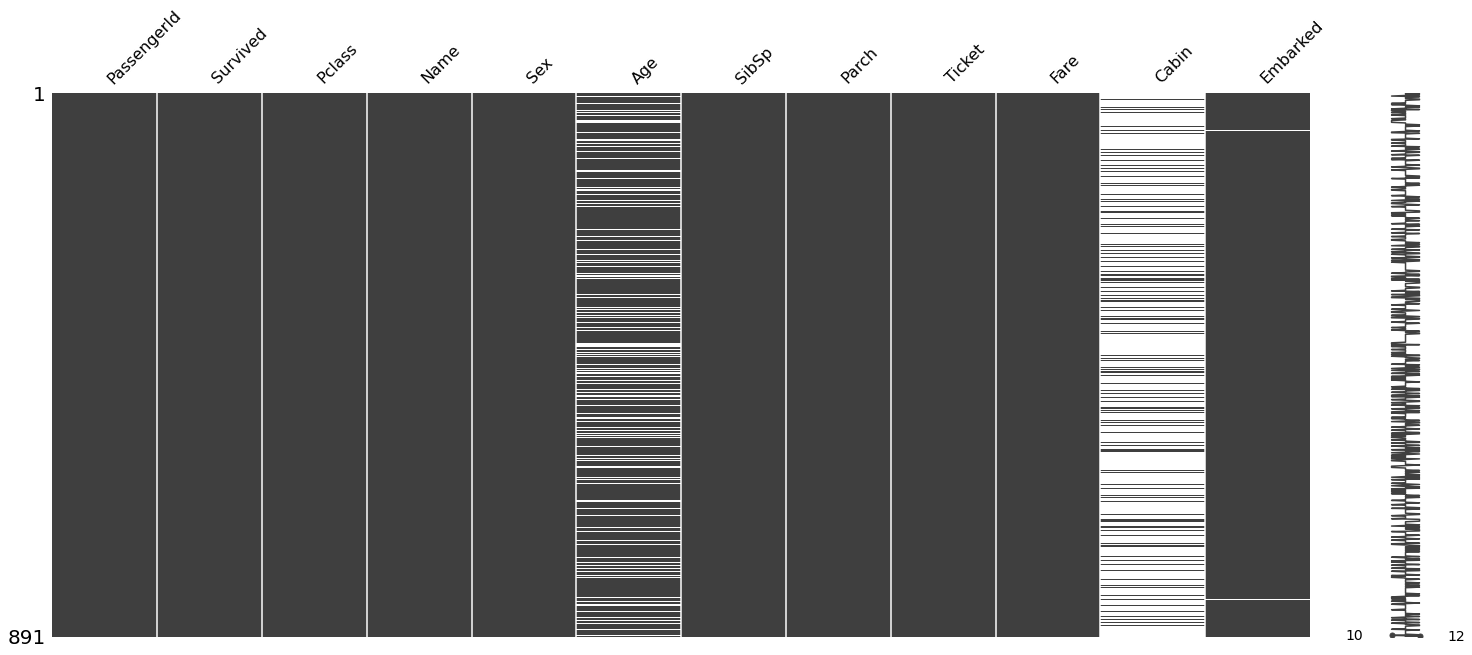

In [13]:
# Missing data in training set

missingno.matrix(train)

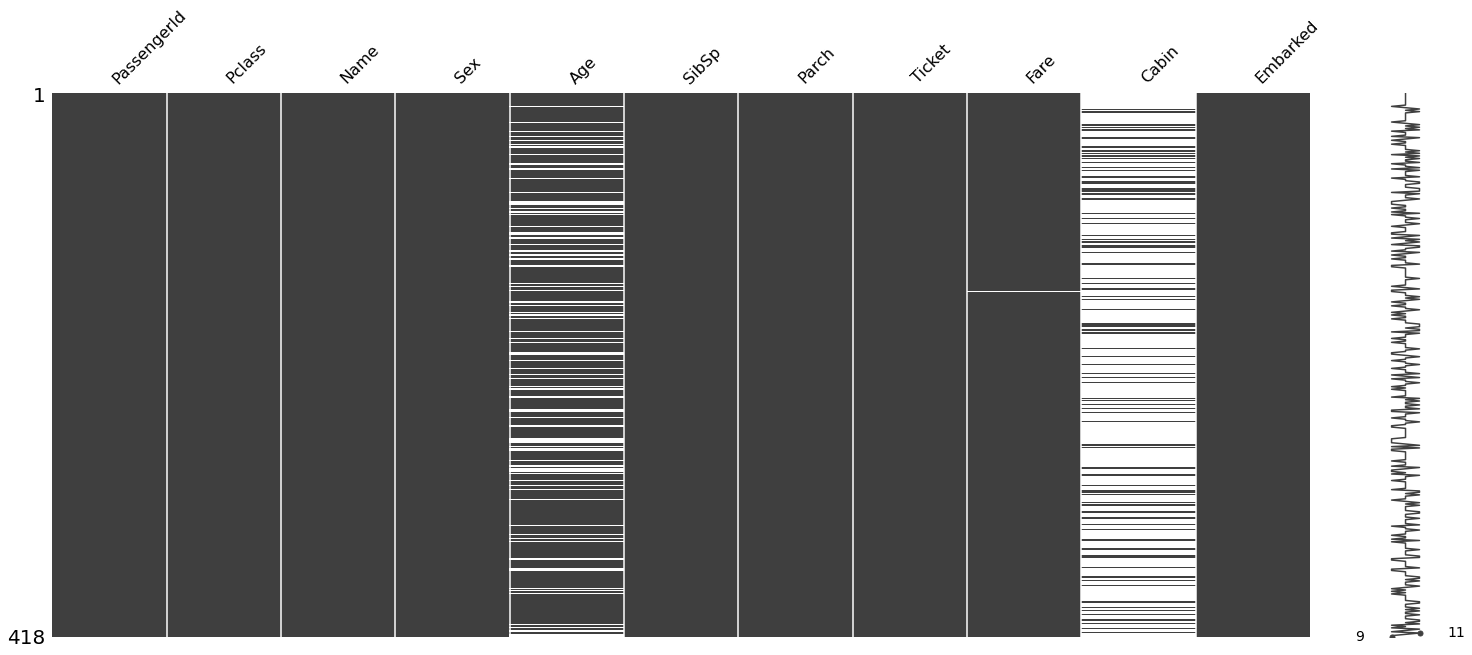

In [14]:
# Missing data in test set 

missingno.matrix(test)

In [15]:
# Summary statistics for training set 

train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [16]:
# Summary statistics for test set 

test.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


## 4.2 Feature analysis

A dataframe is made up of rows and columns. Number of rows correspond to the number of observations in our dataset whereas columns, sometimes called features, represent characteristics that help describe these observations. In our dataset, rows are the passengers on the titanic whereas columns are the features that describe the passengers like their age, gender etc.

Before we move on, it is also important to note the difference between a categorical variable and a numerical variable. Categorical variables, as the name suggests, have values belonging to one of two or more categories and there is usually no intrinsic ordering to these categories. An example of this in our data is the Sex feature. Every passenger is distinctly classified as either male or female. Numerical variables, on the other hand, have a continuous distribution. Some examples of numerical variables are the Age and Fare features.

Knowing if a feature is a numerical variable or categorical variable helps us structure our analysis more properly. For instance, it doesn't make sense to calculate the average of a categorical variable such as gender simply because gender is a binary classification and therefore has no intrinsic ordering to its values.

In this next section of the notebook, we will analyse the features in our dataset individually and see how they correlate with survival probability.

## 4.2.1 Categorical variables

Categorical variables in our dataset are Sex, Pclass and Embarked.

## Categorical variable: Sex

In [17]:
# Value counts of the sex column

train['Sex'].value_counts(dropna = False)

# Comment: There are more male passengers than female passengers on titanic

male      577
female    314
Name: Sex, dtype: int64

In [18]:
# Mean of survival by sex

train[['Sex', 'Survived']].groupby('Sex', as_index = False).mean().sort_values(by = 'Survived', ascending = False)

,Sex,Survived
0,female,0.742038
1,male,0.188908


Text(0.5, 1.0, 'Survival Probability by Gender')

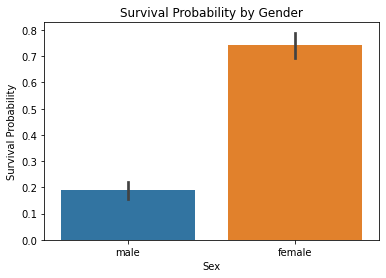

In [19]:
sns.barplot(x = 'Sex', y ='Survived', data = train)
plt.ylabel('Survival Probability')
plt.title('Survival Probability by Gender')

# Comment: Female passengers are more likely to survive

## Categorical variable: Pclass

In [20]:
# Value counts of the Pclass column 

train['Pclass'].value_counts(dropna = False)

3    491
1    216
2    184
Name: Pclass, dtype: int64

In [21]:
# Mean of survival by passenger class

train[['Pclass', 'Survived']].groupby(['Pclass'], as_index = False).mean().sort_values(by = 'Survived', ascending = False)

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


Text(0.5, 1.0, 'Survival Probability by Passenger Class')

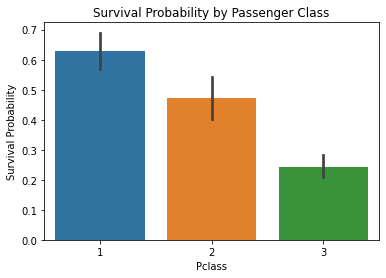

In [22]:
sns.barplot(x = 'Pclass', y ='Survived', data = train)
plt.ylabel('Survival Probability')
plt.title('Survival Probability by Passenger Class')

# Comment: Survival probability decrease with passenger class, first class passengers are prioritised during evacuation

Text(0.5, 1.0, 'Survival Probability by Sex and Passenger Class')

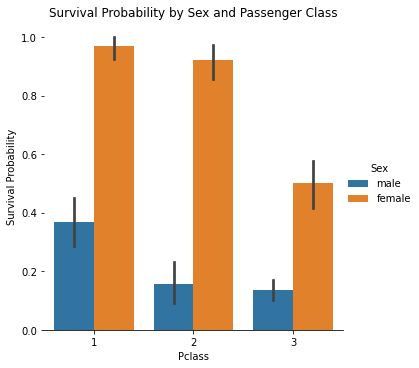

In [23]:
# Survival by gender and passenger class

g = sns.factorplot(x = 'Pclass', y = 'Survived', hue = 'Sex', data = train, kind = 'bar')
g.despine(left = True)
plt.ylabel('Survival Probability')
plt.title('Survival Probability by Sex and Passenger Class')

## Categorical variable: Embarked

In [24]:
# Value counts of the Embarked column 

train['Embarked'].value_counts(dropna = False)

# Comment: Two missing values in the Embarked column

S      644
C      168
Q       77
NaN      2
Name: Embarked, dtype: int64

In [25]:
# Mean of survival by point of embarkation

train[['Embarked', 'Survived']].groupby(['Embarked'], as_index = False).mean().sort_values(by = 'Survived', ascending = False)

,Embarked,Survived
0,C,0.553571
1,Q,0.389610
2,S,0.336957


Text(0.5, 1.0, 'Survival Probability by Point of Embarkation')

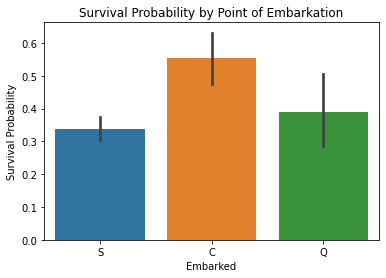

In [26]:
sns.barplot(x = 'Embarked', y ='Survived', data = train)
plt.ylabel('Survival Probability')
plt.title('Survival Probability by Point of Embarkation')

Survival probability is highest for location C and lowest for location S.

Is there a reason for this occurence? We can formulate a hypothesis whereby the majority of the first class passengers have embarked from location C and because they have a highest survival probability, this has resulted in location C having a highest survival probability. Alternatively, there could have been more third class passengers that embarked from location S and because they have the lowest survival probability, this has caused location S to have the lowest survival probability.

Let us now test this hypothesis.

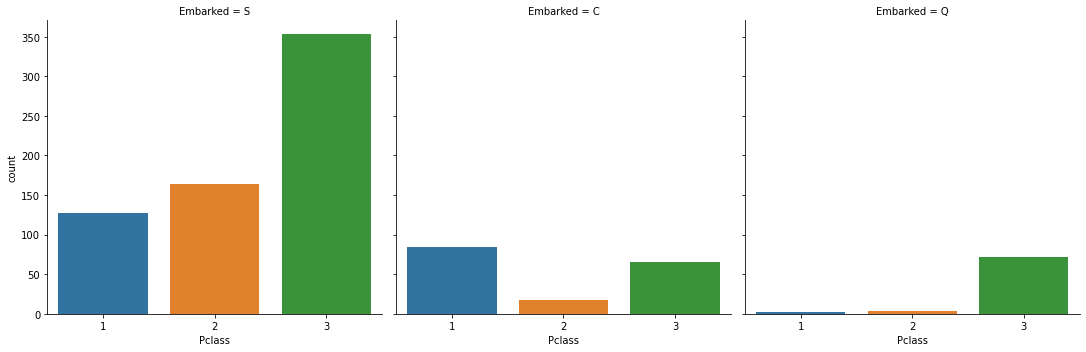

In [27]:
sns.factorplot('Pclass', col = 'Embarked', data = train, kind = 'count')

Our hypothesis appears to be true. Location S has the most third class passengers whereas location C has the most first class passengers. 

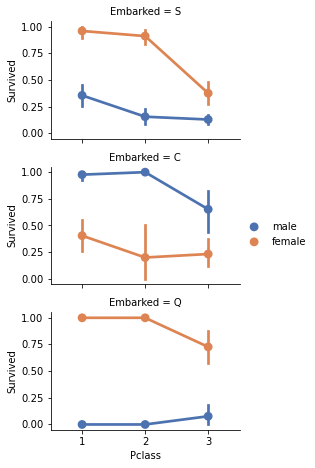

In [28]:
# Survival probability by all categorical variables

grid = sns.FacetGrid(train, row = 'Embarked', size = 2.2, aspect = 1.6)
grid.map(sns.pointplot, 'Pclass', 'Survived', 'Sex', palette = 'deep')
grid.add_legend()

## 4.2.2 Numerical variables

Numerical variables in our dataset are SibSp, Parch, Age and Fare.

## Detect and remove outliers in numerical variables

Outliers are data points that have extreme values and they do not conform with the majority of the data. It is important to address this because outliers tend to skew our data towards extremes and can cause inaccurate model predictions. I will use the Tukey method to remove these outliers.

In [29]:
def detect_outliers(df, n, features):
    """"
    This function will loop through a list of features and detect outliers in each one of those features. In each
    loop, a data point is deemed an outlier if it is less than the first quartile minus the outlier step or exceeds
    third quartile plus the outlier step. The outlier step is defined as 1.5 times the interquartile range. Once the 
    outliers have been determined for one feature, their indices will be stored in a list before proceeding to the next
    feature and the process repeats until the very last feature is completed. Finally, using the list with outlier 
    indices, we will count the frequencies of the index numbers and return them if their frequency exceeds n times.    
    """
    outlier_indices = [] 
    for col in features: 
        Q1 = np.percentile(df[col], 25)
        Q3 = np.percentile(df[col], 75)
        IQR = Q3 - Q1
        outlier_step = 1.5 * IQR 
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step)].index
        outlier_indices.extend(outlier_list_col) 
    outlier_indices = Counter(outlier_indices)
    multiple_outliers = list(key for key, value in outlier_indices.items() if value > n) 
    return multiple_outliers

outliers_to_drop = detect_outliers(train, 2, ['Age', 'SibSp', 'Parch', 'Fare'])
print("We will drop these {} indices: ".format(len(outliers_to_drop)), outliers_to_drop)

We will drop these 10 indices:  [27, 88, 159, 180, 201, 324, 341, 792, 846, 863]


In [30]:
# Outliers in numerical variables

train.loc[outliers_to_drop, :]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.00,C23 C25 C27,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.00,C23 C25 C27,S
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.00,C23 C25 C27,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S


In [31]:
# Drop outliers and reset index

print("Before: {} rows".format(len(train)))
train = train.drop(outliers_to_drop, axis = 0).reset_index(drop = True)
print("After: {} rows".format(len(train)))

Before: 891 rows
After: 881 rows


## Numerical variables correlation with survival

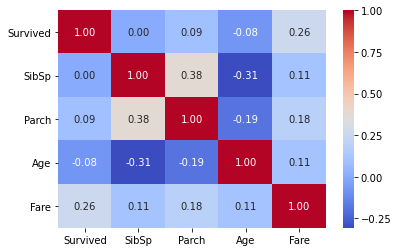

In [32]:
sns.heatmap(train[['Survived', 'SibSp', 'Parch', 'Age', 'Fare']].corr(), annot = True, fmt = '.2f', cmap = 'coolwarm')

# Comment: Fare seems to be the only feature that has a substantial correlation with survival

## Numerical variable: SibSp

In [33]:
# Value counts of the SibSp column 

train['SibSp'].value_counts(dropna = False)

0    608
1    209
2     28
4     18
3     13
5      5
Name: SibSp, dtype: int64

In [34]:
# Mean of survival by SibSp

train[['SibSp', 'Survived']].groupby('SibSp', as_index = False).mean().sort_values(by = 'Survived', ascending = False)

,SibSp,Survived
1,1,0.535885
2,2,0.464286
0,0,0.345395
4,4,0.166667
3,3,0.153846
5,5,0.000000


Text(0.5, 1.0, 'Survival Probability by SibSp')

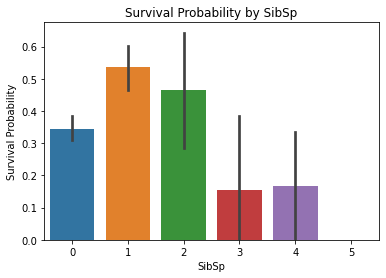

In [35]:
sns.barplot(x = 'SibSp', y ='Survived', data = train)
plt.ylabel('Survival Probability')
plt.title('Survival Probability by SibSp')

## Numerical variable: Parch

In [36]:
# Value counts of the Parch column 

train['Parch'].value_counts(dropna = False)

0    678
1    118
2     70
5      5
3      5
4      4
6      1
Name: Parch, dtype: int64

In [37]:
# Mean of survival by Parch

train[['Parch', 'Survived']].groupby('Parch', as_index = False).mean().sort_values(by = 'Survived', ascending = False)

,Parch,Survived
3,3,0.600000
1,1,0.550847
2,2,0.542857
0,0,0.343658
5,5,0.200000
4,4,0.000000
6,6,0.000000


Text(0.5, 1.0, 'Survival Probability by Parch')

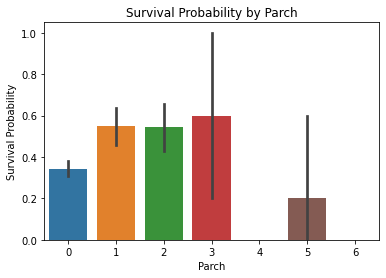

In [38]:
sns.barplot(x = 'Parch', y ='Survived', data = train)
plt.ylabel('Survival Probability')
plt.title('Survival Probability by Parch')

## Numerical variable: Age

In [39]:
# Null values in Age column 

train['Age'].isnull().sum()

170

ValueError: cannot convert float NaN to integer

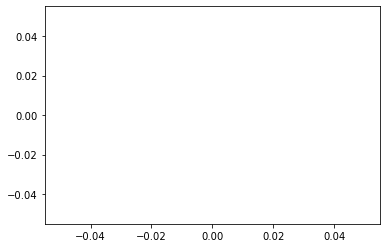

In [40]:
# Passenger age distribution

sns.distplot(train['Age'], label = 'Skewness: %.2f'%(train['Age'].skew()))
plt.legend(loc = 'best')
plt.title('Passenger Age Distribution')

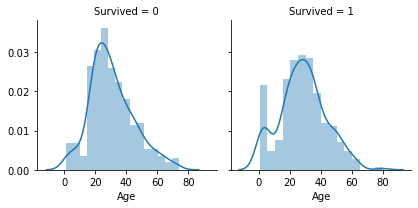

In [41]:
# Age distribution by survival

g = sns.FacetGrid(train, col = 'Survived')
g.map(sns.distplot, 'Age')

Text(0.5, 1.0, 'Passenger Age Distribution by Survival')

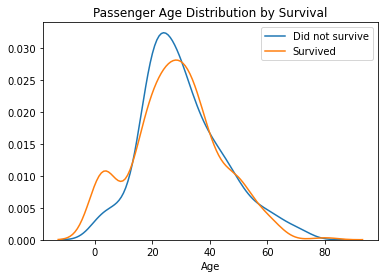

In [42]:
sns.kdeplot(train['Age'][train['Survived'] == 0], label = 'Did not survive')
sns.kdeplot(train['Age'][train['Survived'] == 1], label = 'Survived')
plt.xlabel('Age')
plt.title('Passenger Age Distribution by Survival')

## Numerical variable: Fare

In [43]:
# Null values of Fare column 

train['Fare'].isnull().sum()

0

Text(0, 0.5, 'Passenger Fare Distribution')

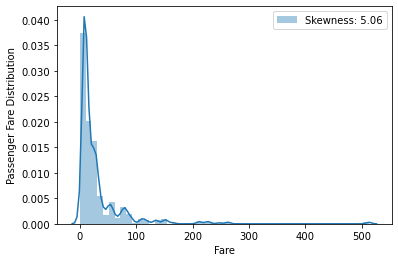

In [44]:
# Passenger fare distribution

sns.distplot(train['Fare'], label = 'Skewness: %.2f'%(train['Fare'].skew()))
plt.legend(loc = 'best')
plt.ylabel('Passenger Fare Distribution')

Fare seems to have a high skewness. We will address this issue later on in the notebook via log transformation. 

# 5. Data preprocessing

Data preprocessing is the process of getting our dataset ready for model training. In this section, we will perform the following preprocessing steps:

- Drop and fill missing values
- Data trasformation (log transformation)
- Feature engineering
- Feature encoding

## 5.1 Drop and fill missing values

In [45]:
# Drop ticket and cabin features from training and test set

train = train.drop(['Ticket', 'Cabin'], axis = 1)
test = test.drop(['Ticket', 'Cabin'], axis = 1)

I have decided to drop both ticket and cabin for simplicity of this tutorial but if you have the time, I would recommend going through them and see if they can help improve your model.

In [46]:
# Missing values in training set 

train.isnull().sum().sort_values(ascending = False)

Age            170
Embarked         2
Fare             0
Parch            0
SibSp            0
Sex              0
Name             0
Pclass           0
Survived         0
PassengerId      0
dtype: int64

In [47]:
# Compute the most frequent value of Embarked in training set

mode = train['Embarked'].dropna().mode()[0]
mode

'S'

In [48]:
# Fill missing value in Embarked with mode

train['Embarked'].fillna(mode, inplace = True)

In [49]:
# Missing values in test set

test.isnull().sum().sort_values(ascending = False)

Age            86
Fare            1
Embarked        0
Parch           0
SibSp           0
Sex             0
Name            0
Pclass          0
PassengerId     0
dtype: int64

In [50]:
# Compute median of Fare in test set 

median = test['Fare'].dropna().median()
median

14.4542

In [51]:
# Fill missing value in Fare with median

test['Fare'].fillna(median, inplace = True)

In [52]:
# Combine training set and test set

combine = pd.concat([train, test], axis = 0).reset_index(drop = True)
combine.head()

,Age,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived
0,22.0,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0
1,38.0,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0
2,26.0,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0
3,35.0,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0
4,35.0,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0


In [53]:
# Missing values in the combined dataset

combine.isnull().sum().sort_values(ascending = False)

Survived       418
Age            256
SibSp            0
Sex              0
Pclass           0
PassengerId      0
Parch            0
Name             0
Fare             0
Embarked         0
dtype: int64

We can ignore missing values in the Survived column because all of them are from the test set. Now we need to fill missing values in the Age column.

The goal is to use features that are most correlated with Age to predict the values for Age. But first, we need to convert Sex into numerical values where 0 = male and 1 = female. This process is known as encoding and we will further explore this later in the notebook.

In [54]:
# Convert Sex into numerical values where 0 = male and 1 = female

combine['Sex'] = combine['Sex'].map({'male': 0, 'female': 1})

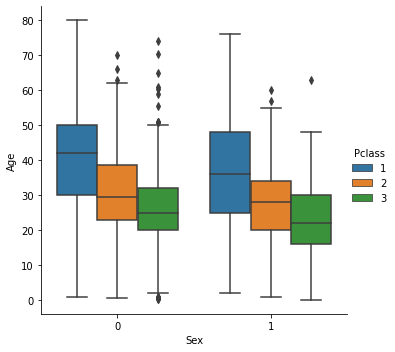

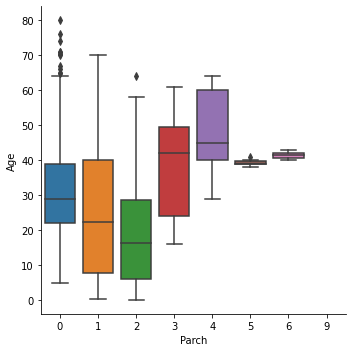

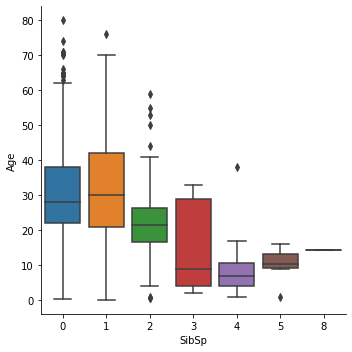

In [55]:
sns.factorplot(y = 'Age', x = 'Sex', hue = 'Pclass', kind = 'box', data = combine)
sns.factorplot(y = 'Age', x = 'Parch', kind = 'box', data = combine)
sns.factorplot(y = 'Age', x = 'SibSp', kind = 'box', data = combine)

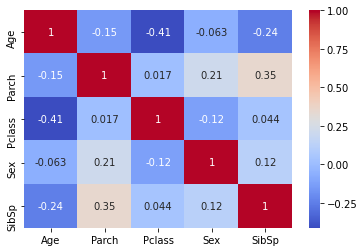

In [56]:
sns.heatmap(combine.drop(['Survived', 'Name', 'PassengerId', 'Fare'], axis = 1).corr(), annot = True, cmap = 'coolwarm')

Age is not correlated with Sex but is negatively correlated with SibSp, Parch and Pclass. 

In [57]:
# Check number of missing ages 

age_nan_indices = list(combine[combine['Age'].isnull()].index)
len(age_nan_indices)

256

Loop through each missing age in the list to locate the rows that have the same SibSp, Parch and PClass values and fill the missing age with the median of those rows. If rows are not found, simply fill the missing age with the median of the entire Age column.

In [58]:
# Loop through list and impute missing ages

for index in age_nan_indices:
    median_age = combine['Age'].median()
    predict_age = combine['Age'][(combine['SibSp'] == combine.iloc[index]['SibSp']) 
                                 & (combine['Parch'] == combine.iloc[index]['Parch'])
                                 & (combine['Pclass'] == combine.iloc[index]["Pclass"])].median()
    if np.isnan(predict_age):
        combine['Age'].iloc[index] = median_age
    else:
        combine['Age'].iloc[index] = predict_age

In [59]:
# Make sure there is no more missing ages 

combine['Age'].isnull().sum()

0

## 5.2 Data transformation

Recall that our passenger fare column has a very high positive skewness. Therefore, we will apply a log transformation to address this issue.

Text(0.5, 1.0, 'Passenger Fare Distribution')

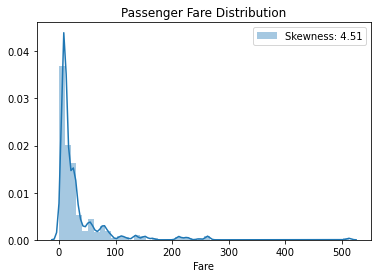

In [60]:
# Passenger fare distribution

sns.distplot(combine['Fare'], label = 'Skewness: %.2f'%(combine['Fare'].skew()))
plt.legend(loc = 'best')
plt.title('Passenger Fare Distribution')

In [61]:
# Apply log transformation to Fare column to reduce skewness

combine['Fare'] = combine['Fare'].map(lambda x: np.log(x) if x > 0 else 0)

Text(0.5, 1.0, 'Passenger Fare Distribution After Log Transformation')

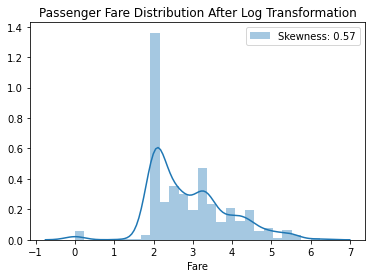

In [62]:
# Passenger fare distribution after log transformation

sns.distplot(combine['Fare'], label = 'Skewness: %.2f'%(combine['Fare'].skew()))
plt.legend(loc = 'best')
plt.title('Passenger Fare Distribution After Log Transformation')

## 5.3 Feature engineering

Feature engineering is arguably the most important art in machine learning. It is the process of creating new features from existing features to better represent the underlying problem to the predictive models resulting in improved model accuracy on unseen data.

In this section, I will construct 3 new features:
- Title
- IsAlone
- Age*Class

## 5.3.1 Title

In [63]:
combine.head()

,Age,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived
0,22.0,S,1.981001,"Braund, Mr. Owen Harris",0,1,3,0,1,0.0
1,38.0,C,4.266662,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,1,1,1.0
2,26.0,S,2.070022,"Heikkinen, Miss. Laina",0,3,3,1,0,1.0
3,35.0,S,3.972177,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,1,1,1.0
4,35.0,S,2.085672,"Allen, Mr. William Henry",0,5,3,0,0,0.0


In [64]:
# Get title from name

combine['Title'] = [name.split(',')[1].split('.')[0].strip() for name in combine['Name']]
combine[['Name', 'Title']].head()

,Name,Title
0,"Braund, Mr. Owen Harris",Mr
1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",Mrs
2,"Heikkinen, Miss. Laina",Miss
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",Mrs
4,"Allen, Mr. William Henry",Mr


In [65]:
# Value counts of Title

combine['Title'].value_counts()

Mr              753
Miss            255
Mrs             197
Master           60
Dr                8
Rev               8
Col               4
Major             2
Ms                2
Mlle              2
Don               1
Lady              1
Mme               1
Capt              1
the Countess      1
Jonkheer          1
Dona              1
Sir               1
Name: Title, dtype: int64

In [66]:
# Number of unique Title

combine['Title'].nunique()

18

In [67]:
# Simplify title

combine['Title'] = combine['Title'].replace(['Dr', 'Rev', 'Col', 'Major', 'Lady', 'Jonkheer', 'Don', 'Capt', 'the Countess',
                                             'Sir', 'Dona'], 'Rare')
combine['Title'] = combine['Title'].replace(['Mlle', 'Ms'], 'Miss')
combine['Title'] = combine['Title'].replace('Mme', 'Mrs')

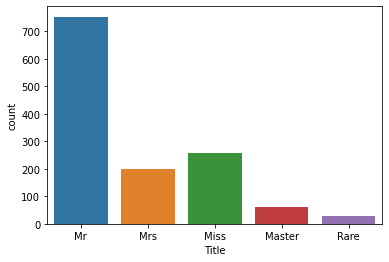

In [68]:
sns.countplot(combine['Title'])

In [69]:
# Mean of survival by name title

combine[['Title', 'Survived']].groupby(['Title'], as_index = False).mean().sort_values(by = 'Survived', ascending = False)

,Title,Survived
3,Mrs,0.793651
1,Miss,0.711111
0,Master,0.589744
4,Rare,0.347826
2,Mr,0.157895


Text(0.5, 1.0, 'Mean of survival by Title')

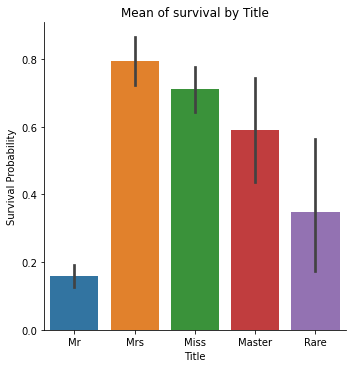

In [70]:
sns.factorplot(x = 'Title', y = 'Survived', data = combine, kind = 'bar')
plt.ylabel('Survival Probability')
plt.title('Mean of survival by Title')

In [71]:
# Drop name column

combine = combine.drop('Name', axis = 1)
combine.head()

,Age,Embarked,Fare,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Title
0,22.0,S,1.981001,0,1,3,0,1,0.0,Mr
1,38.0,C,4.266662,0,2,1,1,1,1.0,Mrs
2,26.0,S,2.070022,0,3,3,1,0,1.0,Miss
3,35.0,S,3.972177,0,4,1,1,1,1.0,Mrs
4,35.0,S,2.085672,0,5,3,0,0,0.0,Mr


## 5.3.2 IsAlone

In [72]:
# Calculate family size from SibSp and Parch

combine['FamilySize'] = combine['SibSp'] + combine['Parch'] + 1
combine[['SibSp', 'Parch', 'FamilySize']].head(10)

,SibSp,Parch,FamilySize
0,1,0,2
1,1,0,2
2,0,0,1
3,1,0,2
4,0,0,1
5,0,0,1
6,0,0,1
7,3,1,5
8,0,2,3
9,1,0,2


In [73]:
# Mean of survival by family size

combine[['FamilySize', 'Survived']].groupby('FamilySize', as_index = False).mean().sort_values(by = 'Survived', ascending = False)

,FamilySize,Survived
3,4,0.724138
2,3,0.578431
1,2,0.552795
6,7,0.333333
0,1,0.303538
4,5,0.200000
5,6,0.052632
7,8,0.000000
8,11,NaN


In [74]:
# Create IsAlone feature

combine['IsAlone'] = 0
combine.loc[combine['FamilySize'] == 1, 'IsAlone'] = 1

In [75]:
# Mean of survival by IsAlone

combine[['IsAlone', 'Survived']].groupby('IsAlone', as_index = False).mean().sort_values(by = 'Survived', ascending = False)

,IsAlone,Survived
0,0,0.514535
1,1,0.303538


In [76]:
# Drop SibSp, Parch and FamilySize features from combine dataframe

combine = combine.drop(['SibSp', 'Parch', 'FamilySize'], axis = 1)
combine.head()

,Age,Embarked,Fare,PassengerId,Pclass,Sex,Survived,Title,IsAlone
0,22.0,S,1.981001,1,3,0,0.0,Mr,0
1,38.0,C,4.266662,2,1,1,1.0,Mrs,0
2,26.0,S,2.070022,3,3,1,1.0,Miss,1
3,35.0,S,3.972177,4,1,1,1.0,Mrs,0
4,35.0,S,2.085672,5,3,0,0.0,Mr,1


## 5.3.3 Age*Class

To create our new Age*Class feature, we need to first transform Age into an ordinal variable. Ordinal variable is much like a categorical variable but with intrisinc ordering in their values. 

We will group Ages into 5 separate age bands and assign a number to each age band.

In [77]:
# Create age bands and compute mean of survival by age bands

combine['AgeBand'] = pd.cut(combine['Age'], 5)
combine[['AgeBand', 'Survived']].groupby('AgeBand', as_index=False).mean().sort_values(by = 'AgeBand')

,AgeBand,Survived
0,"(0.0902, 16.136]",0.532110
1,"(16.136, 32.102]",0.339662
2,"(32.102, 48.068]",0.412844
3,"(48.068, 64.034]",0.434783
4,"(64.034, 80.0]",0.090909


In [78]:
# Assign ordinals to each age band 

combine.loc[combine['Age'] <= 16.136, 'Age'] = 0
combine.loc[(combine['Age'] > 16.136) & (combine['Age'] <= 32.102), 'Age'] = 1
combine.loc[(combine['Age'] > 32.102) & (combine['Age'] <= 48.068), 'Age'] = 2
combine.loc[(combine['Age'] > 48.068) & (combine['Age'] <= 64.034), 'Age'] = 3
combine.loc[combine['Age'] > 64.034 , 'Age'] = 4

In [79]:
# Drop age band feature

combine = combine.drop('AgeBand', axis = 1)

In [80]:
# Age and Pclass data types 

combine[['Age', 'Pclass']].dtypes

Age       float64
Pclass      int64
dtype: object

In [81]:
# Convert ordinal Age into integer

combine['Age'] = combine['Age'].astype('int')
combine['Age'].dtype

dtype('int32')

In [82]:
# Create Age*Class feature

combine['Age*Class'] = combine['Age'] * combine['Pclass']
combine[['Age', 'Pclass', 'Age*Class']].head()

,Age,Pclass,Age*Class
0,1,3,3
1,2,1,2
2,1,3,3
3,2,1,2
4,2,3,6


## 5.4 Feature encoding 

Machine learning models require all input and output variables to be numeric. Therefore, we need to encode all of our categorical data before we can fit the models to our data.

Previously, we have encoded the sex column such that 0 = male and 1 = female. We need to repeat this process for Title and Embarked. In addition, similar to the age column, I will also transform Fare into an ordinal variable rather than a continuous variable.

In [83]:
combine.head()

,Age,Embarked,Fare,PassengerId,Pclass,Sex,Survived,Title,IsAlone,Age*Class
0,1,S,1.981001,1,3,0,0.0,Mr,0,3
1,2,C,4.266662,2,1,1,1.0,Mrs,0,2
2,1,S,2.070022,3,3,1,1.0,Miss,1,3
3,2,S,3.972177,4,1,1,1.0,Mrs,0,2
4,2,S,2.085672,5,3,0,0.0,Mr,1,6


In [84]:
# Encode Title and Embarked feature

combine = pd.get_dummies(combine, columns = ['Title'])
combine = pd.get_dummies(combine, columns = ['Embarked'], prefix = 'Em')
combine.head()

,Age,Fare,PassengerId,Pclass,Sex,Survived,IsAlone,Age*Class,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare,Em_C,Em_Q,Em_S
0,1,1.981001,1,3,0,0.0,0,3,0,0,1,0,0,0,0,1
1,2,4.266662,2,1,1,1.0,0,2,0,0,0,1,0,1,0,0
2,1,2.070022,3,3,1,1.0,1,3,0,1,0,0,0,0,0,1
3,2,3.972177,4,1,1,1.0,0,2,0,0,0,1,0,0,0,1
4,2,2.085672,5,3,0,0.0,1,6,0,0,1,0,0,0,0,1


In [85]:
# Divide Fare into four bands

combine['FareBand'] = pd.cut(combine['Fare'], 4)
combine[['FareBand', 'Survived']].groupby(['FareBand'], as_index=False).mean().sort_values(by = 'FareBand')

,FareBand,Survived
0,"(-0.00624, 1.56]",0.062500
1,"(1.56, 3.119]",0.288719
2,"(3.119, 4.679]",0.517007
3,"(4.679, 6.239]",0.750000


In [86]:
# Assign ordinal to each fare band

combine.loc[combine['Fare'] <= 1.56, 'Fare'] = 0
combine.loc[(combine['Fare'] > 1.56) & (combine['Fare'] <= 3.119), 'Fare'] = 1
combine.loc[(combine['Fare'] > 3.119) & (combine['Fare'] <= 4.679), 'Fare'] = 2
combine.loc[combine['Fare'] > 4.679, 'Fare'] = 3

In [87]:
# Convert Fare into integer

combine['Fare'] = combine['Fare'].astype('int')

In [88]:
# Drop FareBand feature

combine = combine.drop('FareBand', axis = 1)

In [89]:
combine.head()

,Age,Fare,PassengerId,Pclass,Sex,Survived,IsAlone,Age*Class,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare,Em_C,Em_Q,Em_S
0,1,1,1,3,0,0.0,0,3,0,0,1,0,0,0,0,1
1,2,2,2,1,1,1.0,0,2,0,0,0,1,0,1,0,0
2,1,1,3,3,1,1.0,1,3,0,1,0,0,0,0,0,1
3,2,2,4,1,1,1.0,0,2,0,0,0,1,0,0,0,1
4,2,1,5,3,0,0.0,1,6,0,0,1,0,0,0,0,1


In [91]:
# Separate training and test set from the combined dataframe

train = combine[:len(train)]
test = combine[len(train):]

In [92]:
train.head()

,Age,Fare,PassengerId,Pclass,Sex,Survived,IsAlone,Age*Class,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare,Em_C,Em_Q,Em_S
0,1,1,1,3,0,0.0,0,3,0,0,1,0,0,0,0,1
1,2,2,2,1,1,1.0,0,2,0,0,0,1,0,1,0,0
2,1,1,3,3,1,1.0,1,3,0,1,0,0,0,0,0,1
3,2,2,4,1,1,1.0,0,2,0,0,0,1,0,0,0,1
4,2,1,5,3,0,0.0,1,6,0,0,1,0,0,0,0,1


In [93]:
# Drop passenger ID column from and training set

train = train.drop('PassengerId', axis = 1)
train.head()

,Age,Fare,Pclass,Sex,Survived,IsAlone,Age*Class,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare,Em_C,Em_Q,Em_S
0,1,1,3,0,0.0,0,3,0,0,1,0,0,0,0,1
1,2,2,1,1,1.0,0,2,0,0,0,1,0,1,0,0
2,1,1,3,1,1.0,1,3,0,1,0,0,0,0,0,1
3,2,2,1,1,1.0,0,2,0,0,0,1,0,0,0,1
4,2,1,3,0,0.0,1,6,0,0,1,0,0,0,0,1


In [94]:
# Convert survived back to integer in the training set

train['Survived'] = train['Survived'].astype('int')
train.head()

,Age,Fare,Pclass,Sex,Survived,IsAlone,Age*Class,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare,Em_C,Em_Q,Em_S
0,1,1,3,0,0,0,3,0,0,1,0,0,0,0,1
1,2,2,1,1,1,0,2,0,0,0,1,0,1,0,0
2,1,1,3,1,1,1,3,0,1,0,0,0,0,0,1
3,2,2,1,1,1,0,2,0,0,0,1,0,0,0,1
4,2,1,3,0,0,1,6,0,0,1,0,0,0,0,1


In [95]:
test.head()

,Age,Fare,PassengerId,Pclass,Sex,Survived,IsAlone,Age*Class,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare,Em_C,Em_Q,Em_S
881,2,1,892,3,0,NaN,1,6,0,0,1,0,0,0,1,0
882,2,1,893,3,1,NaN,0,6,0,0,0,1,0,0,0,1
883,3,1,894,2,0,NaN,1,6,0,0,1,0,0,0,1,0
884,1,1,895,3,0,NaN,1,3,0,0,1,0,0,0,0,1
885,1,1,896,3,1,NaN,0,3,0,0,0,1,0,0,0,1


In [96]:
# Drop passenger survived column from test set

test = test.drop('Survived', axis = 1)
test.head()

,Age,Fare,PassengerId,Pclass,Sex,IsAlone,Age*Class,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare,Em_C,Em_Q,Em_S
881,2,1,892,3,0,1,6,0,0,1,0,0,0,1,0
882,2,1,893,3,1,0,6,0,0,0,1,0,0,0,1
883,3,1,894,2,0,1,6,0,0,1,0,0,0,1,0
884,1,1,895,3,0,1,3,0,0,1,0,0,0,0,1
885,1,1,896,3,1,0,3,0,0,0,1,0,0,0,1


Our dataframes are ready for modelling!

# 6. Modelling

Scikit-learn is one of the most popular libraries for machine learning in Python and that is what we will use in the modelling part of this project. 

Since Titanic is a classfication problem, we will need to use classfication models, also known as classifiers, to train on our model to make predictions. I highly recommend checking out this scikit-learn [documentation](https://scikit-learn.org/stable/index.html) for more information on the different machine learning models available in their library. I have chosen the following classifiers for the job:

- Logistic regression
- Support vector machines
- K-nearest neighbours
- Gaussian naive bayes
- Perceptron
- Linear SVC
- Stochastic gradient descent
- Decision tree
- Random forest
- CatBoost

In this section of the notebook, I will fit the models to the training set as outlined above and evaluate their accuracy at making predictions. Once the best model is determined, I will also do hyperparameter tuning to further boost the performance of the best model.

## 6.1 Split training data

We need to first split our training data into independent variables or predictor variables, represented by X as well as  dependent variable or response variable, represented by Y.

Y_train is the survived column in our training set and X_train is the other columns in the training set excluding the Survived column. Our models will learn to classify survival, Y_train based on all X_train and make predictions on X_test.

In [97]:
X_train = train.drop('Survived', axis = 1)
Y_train = train['Survived']
X_test = test.drop('PassengerId', axis = 1).copy()
print("X_train shape: ", X_train.shape)
print("Y_train shape: ", Y_train.shape)
print("X_test shape: ", X_test.shape)

X_train shape:  (881, 14)
Y_train shape:  (881,)
X_test shape:  (418, 14)


## 6.2 Fit model to data and make predictions

This requires 3 simple steps: instantiate the model, fit the model to the training set and predict the data in test set. 

## 6.2.1 Logistic regression

In [98]:
logreg = LogisticRegression()
logreg.fit(X_train, Y_train)
Y_pred = logreg.predict(X_test)
acc_log = round(logreg.score(X_train, Y_train) * 100, 2)
acc_log

80.7

## 6.2.2 Support vector machines

In [99]:
svc = SVC()
svc.fit(X_train, Y_train)
Y_pred = svc.predict(X_test)
acc_svc = round(svc.score(X_train, Y_train) * 100, 2)
acc_svc

83.09

## 6.2.3 K-nearest neighbours (KNN)

In [100]:
knn = KNeighborsClassifier(n_neighbors = 5)
knn.fit(X_train, Y_train)
Y_pred = knn.predict(X_test)
acc_knn = round(knn.score(X_train, Y_train) * 100, 2)
acc_knn

84.68

## 6.2.4 Gaussian naive bayes

In [101]:
gaussian = GaussianNB()
gaussian.fit(X_train, Y_train)
Y_pred = gaussian.predict(X_test)
acc_gaussian = round(gaussian.score(X_train, Y_train) * 100, 2)
acc_gaussian

79.11

## 6.2.5 Perceptron

In [102]:
perceptron = Perceptron()
perceptron.fit(X_train, Y_train)
Y_pred = perceptron.predict(X_test)
acc_perceptron = round(perceptron.score(X_train, Y_train) * 100, 2)
acc_perceptron

80.25

## 6.2.6 Linear SVC

In [103]:
linear_svc = LinearSVC()
linear_svc.fit(X_train, Y_train)
Y_pred = linear_svc.predict(X_test)
acc_linear_svc = round(linear_svc.score(X_train, Y_train) * 100, 2)
acc_linear_svc

80.25

## 6.2.7 Stochastic gradient descent

In [104]:
sgd = SGDClassifier()
sgd.fit(X_train, Y_train)
Y_pred = sgd.predict(X_test)
acc_sgd = round(sgd.score(X_train, Y_train) * 100, 2)
acc_sgd

78.09

## 6.2.8 Decision tree

In [105]:
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, Y_train)
Y_pred = decision_tree.predict(X_test)
acc_decision_tree = round(decision_tree.score(X_train, Y_train) * 100, 2)
acc_decision_tree

85.7

## 6.2.9 Random forest

In [106]:
random_forest = RandomForestClassifier(n_estimators = 100)
random_forest.fit(X_train, Y_train)
Y_pred = random_forest.predict(X_test)
acc_random_forest = round(random_forest.score(X_train, Y_train) * 100, 2)
acc_random_forest

85.7

## 6.2.10 CatBoost

In [107]:
catboost = CatBoostClassifier()
catboost.fit(X_train, Y_train)
Y_pred = catboost.predict(X_test)
acc_catboost = round(catboost.score(X_train, Y_train) * 100, 2)

Learning rate set to 0.00976
0:	learn: 0.6867798	total: 56.3ms	remaining: 56.3s
1:	learn: 0.6795853	total: 57.8ms	remaining: 28.8s
2:	learn: 0.6731092	total: 59.1ms	remaining: 19.6s
3:	learn: 0.6664186	total: 60.6ms	remaining: 15.1s
4:	learn: 0.6604809	total: 62.1ms	remaining: 12.4s
5:	learn: 0.6542334	total: 63.6ms	remaining: 10.5s
6:	learn: 0.6483206	total: 64.8ms	remaining: 9.19s
7:	learn: 0.6427265	total: 65.9ms	remaining: 8.17s
8:	learn: 0.6376021	total: 67.2ms	remaining: 7.4s
9:	learn: 0.6321832	total: 68.6ms	remaining: 6.79s
10:	learn: 0.6265958	total: 70.1ms	remaining: 6.3s
11:	learn: 0.6210364	total: 71.3ms	remaining: 5.87s
12:	learn: 0.6180905	total: 72.5ms	remaining: 5.5s
13:	learn: 0.6135151	total: 74.1ms	remaining: 5.21s
14:	learn: 0.6088314	total: 75.4ms	remaining: 4.95s
15:	learn: 0.6035553	total: 77ms	remaining: 4.73s
16:	learn: 0.5991222	total: 78.7ms	remaining: 4.55s
17:	learn: 0.5943844	total: 79.9ms	remaining: 4.36s
18:	learn: 0.5907208	total: 81.5ms	remaining: 4.21

217:	learn: 0.3794331	total: 311ms	remaining: 1.11s
218:	learn: 0.3791971	total: 312ms	remaining: 1.11s
219:	learn: 0.3789993	total: 313ms	remaining: 1.11s
220:	learn: 0.3789661	total: 314ms	remaining: 1.11s
221:	learn: 0.3788137	total: 315ms	remaining: 1.1s
222:	learn: 0.3786646	total: 316ms	remaining: 1.1s
223:	learn: 0.3785026	total: 317ms	remaining: 1.1s
224:	learn: 0.3783015	total: 319ms	remaining: 1.1s
225:	learn: 0.3781670	total: 321ms	remaining: 1.1s
226:	learn: 0.3780028	total: 322ms	remaining: 1.09s
227:	learn: 0.3777161	total: 323ms	remaining: 1.09s
228:	learn: 0.3774762	total: 324ms	remaining: 1.09s
229:	learn: 0.3773422	total: 325ms	remaining: 1.09s
230:	learn: 0.3772028	total: 326ms	remaining: 1.09s
231:	learn: 0.3769760	total: 327ms	remaining: 1.08s
232:	learn: 0.3768444	total: 328ms	remaining: 1.08s
233:	learn: 0.3766736	total: 329ms	remaining: 1.08s
234:	learn: 0.3765120	total: 331ms	remaining: 1.08s
235:	learn: 0.3764835	total: 331ms	remaining: 1.07s
236:	learn: 0.376

470:	learn: 0.3550569	total: 602ms	remaining: 676ms
471:	learn: 0.3550557	total: 603ms	remaining: 675ms
472:	learn: 0.3549863	total: 604ms	remaining: 673ms
473:	learn: 0.3549431	total: 605ms	remaining: 671ms
474:	learn: 0.3548591	total: 606ms	remaining: 670ms
475:	learn: 0.3547773	total: 607ms	remaining: 668ms
476:	learn: 0.3546621	total: 608ms	remaining: 667ms
477:	learn: 0.3546380	total: 609ms	remaining: 665ms
478:	learn: 0.3545588	total: 610ms	remaining: 664ms
479:	learn: 0.3544453	total: 612ms	remaining: 663ms
480:	learn: 0.3543553	total: 613ms	remaining: 661ms
481:	learn: 0.3543137	total: 614ms	remaining: 660ms
482:	learn: 0.3542391	total: 615ms	remaining: 658ms
483:	learn: 0.3541337	total: 616ms	remaining: 657ms
484:	learn: 0.3540571	total: 617ms	remaining: 656ms
485:	learn: 0.3540049	total: 619ms	remaining: 654ms
486:	learn: 0.3539282	total: 620ms	remaining: 653ms
487:	learn: 0.3538688	total: 621ms	remaining: 651ms
488:	learn: 0.3538338	total: 622ms	remaining: 650ms
489:	learn: 

748:	learn: 0.3416525	total: 895ms	remaining: 300ms
749:	learn: 0.3416098	total: 896ms	remaining: 299ms
750:	learn: 0.3415590	total: 898ms	remaining: 298ms
751:	learn: 0.3415307	total: 899ms	remaining: 296ms
752:	learn: 0.3414931	total: 900ms	remaining: 295ms
753:	learn: 0.3414264	total: 901ms	remaining: 294ms
754:	learn: 0.3413516	total: 902ms	remaining: 293ms
755:	learn: 0.3412880	total: 903ms	remaining: 292ms
756:	learn: 0.3412266	total: 904ms	remaining: 290ms
757:	learn: 0.3411666	total: 905ms	remaining: 289ms
758:	learn: 0.3411299	total: 906ms	remaining: 288ms
759:	learn: 0.3410565	total: 908ms	remaining: 287ms
760:	learn: 0.3410289	total: 909ms	remaining: 285ms
761:	learn: 0.3410228	total: 909ms	remaining: 284ms
762:	learn: 0.3409805	total: 910ms	remaining: 283ms
763:	learn: 0.3409257	total: 912ms	remaining: 282ms
764:	learn: 0.3408686	total: 913ms	remaining: 280ms
765:	learn: 0.3408317	total: 914ms	remaining: 279ms
766:	learn: 0.3407767	total: 916ms	remaining: 278ms
767:	learn: 

In [108]:
acc_catboost

85.7

## 6.3 Model evaluation and hyperparameter tuning

Once all our models have been trained, the next step is to assess the performance of these models and select the one which has the highest prediction accuracy. 

## 6.3.1 Training accuracy

Training accuracy shows how well our model has learned from the training set. 

In [110]:
models = pd.DataFrame({'Model': ['Support Vector Machines', 'KNN', 'Logistic Regression', 
                                 'Random Forest', 'Naive Bayes', 'Perceptron', 'Stochastic Gradient Decent', 
                                 'Linear SVC', 'Decision Tree', 'CatBoost'],
                       'Score': [acc_svc, acc_knn, acc_log, acc_random_forest, acc_gaussian, acc_perceptron,
                                 acc_sgd, acc_linear_svc, acc_decision_tree, acc_catboost]})

models.sort_values(by = 'Score', ascending = False)

,Model,Score
3,Random Forest,85.70
8,Decision Tree,85.70
9,CatBoost,85.70
1,KNN,84.68
0,Support Vector Machines,83.09
2,Logistic Regression,80.70
5,Perceptron,80.25
7,Linear SVC,80.25
4,Naive Bayes,79.11
6,Stochastic Gradient Decent,78.09


## 6.3.2 K-fold cross validation

It is important to not get too carried away with models with impressive training accuracy as what we should focus on instead is the model's ability to predict out-of-samples data, in other words, data our model has not seen before.

This is where k-fold cross validation comes in. K-fold cross validation is a technique whereby a subset of our training set is kept aside and will act as holdout set for testing purposes. Here is a great [video](https://www.youtube.com/watch?v=fSytzGwwBVw) explaining the concept in more detail. 

In [111]:
# Create a list which contains classifiers 

classifiers = []
classifiers.append(LogisticRegression())
classifiers.append(SVC())
classifiers.append(KNeighborsClassifier(n_neighbors = 5))
classifiers.append(GaussianNB())
classifiers.append(Perceptron())
classifiers.append(LinearSVC())
classifiers.append(SGDClassifier())
classifiers.append(DecisionTreeClassifier())
classifiers.append(RandomForestClassifier())
classifiers.append(CatBoostClassifier())

len(classifiers)

10

In [112]:
# Create a list which contains cross validation results for each classifier

cv_results = []
for classifier in classifiers:
    cv_results.append(cross_val_score(classifier, X_train, Y_train, scoring = 'accuracy', cv = 10))

Learning rate set to 0.009326
0:	learn: 0.6870531	total: 1.31ms	remaining: 1.31s
1:	learn: 0.6802614	total: 2.48ms	remaining: 1.24s
2:	learn: 0.6739719	total: 3.98ms	remaining: 1.32s
3:	learn: 0.6674741	total: 5.37ms	remaining: 1.34s
4:	learn: 0.6616762	total: 6.61ms	remaining: 1.31s
5:	learn: 0.6554314	total: 8.15ms	remaining: 1.35s
6:	learn: 0.6496824	total: 10ms	remaining: 1.42s
7:	learn: 0.6443219	total: 11.1ms	remaining: 1.38s
8:	learn: 0.6386665	total: 12.5ms	remaining: 1.37s
9:	learn: 0.6351223	total: 13.5ms	remaining: 1.33s
10:	learn: 0.6312410	total: 14.8ms	remaining: 1.33s
11:	learn: 0.6255060	total: 16.3ms	remaining: 1.34s
12:	learn: 0.6211866	total: 17.7ms	remaining: 1.35s
13:	learn: 0.6167118	total: 19ms	remaining: 1.34s
14:	learn: 0.6118133	total: 20.2ms	remaining: 1.33s
15:	learn: 0.6079335	total: 21.3ms	remaining: 1.31s
16:	learn: 0.6037286	total: 22.8ms	remaining: 1.32s
17:	learn: 0.5991811	total: 24ms	remaining: 1.31s
18:	learn: 0.5953495	total: 25.2ms	remaining: 1.3s

241:	learn: 0.3727099	total: 280ms	remaining: 878ms
242:	learn: 0.3725547	total: 281ms	remaining: 876ms
243:	learn: 0.3724631	total: 282ms	remaining: 875ms
244:	learn: 0.3722825	total: 283ms	remaining: 873ms
245:	learn: 0.3721175	total: 284ms	remaining: 872ms
246:	learn: 0.3718561	total: 286ms	remaining: 870ms
247:	learn: 0.3716578	total: 287ms	remaining: 869ms
248:	learn: 0.3715748	total: 288ms	remaining: 868ms
249:	learn: 0.3714627	total: 289ms	remaining: 866ms
250:	learn: 0.3714498	total: 290ms	remaining: 864ms
251:	learn: 0.3712993	total: 291ms	remaining: 863ms
252:	learn: 0.3711172	total: 292ms	remaining: 862ms
253:	learn: 0.3710368	total: 293ms	remaining: 860ms
254:	learn: 0.3709119	total: 294ms	remaining: 859ms
255:	learn: 0.3707780	total: 295ms	remaining: 858ms
256:	learn: 0.3706500	total: 296ms	remaining: 857ms
257:	learn: 0.3703934	total: 298ms	remaining: 856ms
258:	learn: 0.3701695	total: 299ms	remaining: 855ms
259:	learn: 0.3700353	total: 300ms	remaining: 854ms
260:	learn: 

515:	learn: 0.3468613	total: 579ms	remaining: 543ms
516:	learn: 0.3468136	total: 580ms	remaining: 542ms
517:	learn: 0.3467671	total: 581ms	remaining: 541ms
518:	learn: 0.3467516	total: 582ms	remaining: 539ms
519:	learn: 0.3467430	total: 583ms	remaining: 538ms
520:	learn: 0.3467015	total: 584ms	remaining: 537ms
521:	learn: 0.3465947	total: 585ms	remaining: 536ms
522:	learn: 0.3464753	total: 586ms	remaining: 534ms
523:	learn: 0.3464334	total: 587ms	remaining: 533ms
524:	learn: 0.3463841	total: 588ms	remaining: 532ms
525:	learn: 0.3463303	total: 589ms	remaining: 531ms
526:	learn: 0.3463041	total: 590ms	remaining: 529ms
527:	learn: 0.3462548	total: 591ms	remaining: 528ms
528:	learn: 0.3461450	total: 592ms	remaining: 527ms
529:	learn: 0.3461327	total: 593ms	remaining: 526ms
530:	learn: 0.3460764	total: 594ms	remaining: 524ms
531:	learn: 0.3460048	total: 595ms	remaining: 523ms
532:	learn: 0.3459640	total: 596ms	remaining: 522ms
533:	learn: 0.3458918	total: 597ms	remaining: 521ms
534:	learn: 

673:	learn: 0.3387294	total: 737ms	remaining: 356ms
674:	learn: 0.3387292	total: 738ms	remaining: 355ms
675:	learn: 0.3386887	total: 739ms	remaining: 354ms
676:	learn: 0.3386435	total: 740ms	remaining: 353ms
677:	learn: 0.3386001	total: 741ms	remaining: 352ms
678:	learn: 0.3385250	total: 742ms	remaining: 351ms
679:	learn: 0.3384206	total: 743ms	remaining: 350ms
680:	learn: 0.3383441	total: 744ms	remaining: 349ms
681:	learn: 0.3382938	total: 745ms	remaining: 347ms
682:	learn: 0.3382684	total: 746ms	remaining: 346ms
683:	learn: 0.3382283	total: 747ms	remaining: 345ms
684:	learn: 0.3381339	total: 748ms	remaining: 344ms
685:	learn: 0.3380833	total: 749ms	remaining: 343ms
686:	learn: 0.3380491	total: 750ms	remaining: 342ms
687:	learn: 0.3379955	total: 752ms	remaining: 341ms
688:	learn: 0.3379897	total: 752ms	remaining: 340ms
689:	learn: 0.3378988	total: 753ms	remaining: 339ms
690:	learn: 0.3378739	total: 755ms	remaining: 337ms
691:	learn: 0.3378441	total: 756ms	remaining: 336ms
692:	learn: 

955:	learn: 0.3254659	total: 1.03s	remaining: 47.5ms
956:	learn: 0.3254306	total: 1.03s	remaining: 46.4ms
957:	learn: 0.3253567	total: 1.03s	remaining: 45.4ms
958:	learn: 0.3253078	total: 1.03s	remaining: 44.3ms
959:	learn: 0.3252540	total: 1.04s	remaining: 43.2ms
960:	learn: 0.3252210	total: 1.04s	remaining: 42.1ms
961:	learn: 0.3251715	total: 1.04s	remaining: 41ms
962:	learn: 0.3251325	total: 1.04s	remaining: 39.9ms
963:	learn: 0.3251034	total: 1.04s	remaining: 38.9ms
964:	learn: 0.3250724	total: 1.04s	remaining: 37.8ms
965:	learn: 0.3250463	total: 1.04s	remaining: 36.7ms
966:	learn: 0.3249886	total: 1.04s	remaining: 35.6ms
967:	learn: 0.3249572	total: 1.04s	remaining: 34.5ms
968:	learn: 0.3249084	total: 1.04s	remaining: 33.5ms
969:	learn: 0.3248659	total: 1.05s	remaining: 32.4ms
970:	learn: 0.3248334	total: 1.05s	remaining: 31.3ms
971:	learn: 0.3248027	total: 1.05s	remaining: 30.2ms
972:	learn: 0.3247806	total: 1.05s	remaining: 29.1ms
973:	learn: 0.3247561	total: 1.05s	remaining: 28

205:	learn: 0.3848861	total: 226ms	remaining: 873ms
206:	learn: 0.3847621	total: 227ms	remaining: 871ms
207:	learn: 0.3844757	total: 229ms	remaining: 871ms
208:	learn: 0.3840622	total: 230ms	remaining: 870ms
209:	learn: 0.3837723	total: 231ms	remaining: 869ms
210:	learn: 0.3834587	total: 232ms	remaining: 868ms
211:	learn: 0.3833225	total: 233ms	remaining: 867ms
212:	learn: 0.3830110	total: 234ms	remaining: 865ms
213:	learn: 0.3829107	total: 235ms	remaining: 864ms
214:	learn: 0.3825577	total: 236ms	remaining: 863ms
215:	learn: 0.3823684	total: 237ms	remaining: 862ms
216:	learn: 0.3821039	total: 238ms	remaining: 860ms
217:	learn: 0.3820034	total: 239ms	remaining: 859ms
218:	learn: 0.3816757	total: 240ms	remaining: 857ms
219:	learn: 0.3813893	total: 242ms	remaining: 856ms
220:	learn: 0.3812212	total: 243ms	remaining: 856ms
221:	learn: 0.3810456	total: 244ms	remaining: 855ms
222:	learn: 0.3810006	total: 245ms	remaining: 853ms
223:	learn: 0.3809036	total: 246ms	remaining: 851ms
224:	learn: 

467:	learn: 0.3542515	total: 527ms	remaining: 599ms
468:	learn: 0.3541835	total: 529ms	remaining: 598ms
469:	learn: 0.3541612	total: 530ms	remaining: 597ms
470:	learn: 0.3540590	total: 531ms	remaining: 596ms
471:	learn: 0.3540037	total: 532ms	remaining: 596ms
472:	learn: 0.3538794	total: 534ms	remaining: 595ms
473:	learn: 0.3538480	total: 535ms	remaining: 594ms
474:	learn: 0.3538091	total: 536ms	remaining: 593ms
475:	learn: 0.3537077	total: 537ms	remaining: 592ms
476:	learn: 0.3537009	total: 539ms	remaining: 591ms
477:	learn: 0.3536469	total: 540ms	remaining: 590ms
478:	learn: 0.3536111	total: 541ms	remaining: 589ms
479:	learn: 0.3535970	total: 542ms	remaining: 587ms
480:	learn: 0.3535218	total: 543ms	remaining: 586ms
481:	learn: 0.3534052	total: 545ms	remaining: 585ms
482:	learn: 0.3533125	total: 546ms	remaining: 584ms
483:	learn: 0.3532895	total: 547ms	remaining: 583ms
484:	learn: 0.3531581	total: 548ms	remaining: 582ms
485:	learn: 0.3531173	total: 550ms	remaining: 581ms
486:	learn: 

736:	learn: 0.3411942	total: 823ms	remaining: 294ms
737:	learn: 0.3411271	total: 824ms	remaining: 292ms
738:	learn: 0.3410955	total: 825ms	remaining: 291ms
739:	learn: 0.3410700	total: 826ms	remaining: 290ms
740:	learn: 0.3410226	total: 827ms	remaining: 289ms
741:	learn: 0.3409702	total: 828ms	remaining: 288ms
742:	learn: 0.3409259	total: 829ms	remaining: 287ms
743:	learn: 0.3408847	total: 830ms	remaining: 286ms
744:	learn: 0.3408494	total: 831ms	remaining: 284ms
745:	learn: 0.3408011	total: 832ms	remaining: 283ms
746:	learn: 0.3407544	total: 833ms	remaining: 282ms
747:	learn: 0.3406989	total: 834ms	remaining: 281ms
748:	learn: 0.3406788	total: 835ms	remaining: 280ms
749:	learn: 0.3406003	total: 836ms	remaining: 279ms
750:	learn: 0.3405842	total: 837ms	remaining: 278ms
751:	learn: 0.3405420	total: 838ms	remaining: 276ms
752:	learn: 0.3404772	total: 839ms	remaining: 275ms
753:	learn: 0.3404183	total: 840ms	remaining: 274ms
754:	learn: 0.3404031	total: 841ms	remaining: 273ms
755:	learn: 

Learning rate set to 0.009331
0:	learn: 0.6860901	total: 1.18ms	remaining: 1.18s
1:	learn: 0.6786698	total: 2.34ms	remaining: 1.17s
2:	learn: 0.6728492	total: 3.22ms	remaining: 1.07s
3:	learn: 0.6657338	total: 4.33ms	remaining: 1.08s
4:	learn: 0.6603775	total: 5.42ms	remaining: 1.08s
5:	learn: 0.6540572	total: 6.53ms	remaining: 1.08s
6:	learn: 0.6481533	total: 7.7ms	remaining: 1.09s
7:	learn: 0.6416269	total: 8.78ms	remaining: 1.09s
8:	learn: 0.6361027	total: 9.84ms	remaining: 1.08s
9:	learn: 0.6314911	total: 10.9ms	remaining: 1.08s
10:	learn: 0.6264115	total: 11.8ms	remaining: 1.06s
11:	learn: 0.6204366	total: 12.9ms	remaining: 1.06s
12:	learn: 0.6149788	total: 14.1ms	remaining: 1.07s
13:	learn: 0.6098221	total: 15.2ms	remaining: 1.07s
14:	learn: 0.6053659	total: 16.2ms	remaining: 1.06s
15:	learn: 0.6004794	total: 17.4ms	remaining: 1.07s
16:	learn: 0.5968370	total: 18.5ms	remaining: 1.07s
17:	learn: 0.5916776	total: 19.5ms	remaining: 1.06s
18:	learn: 0.5861544	total: 20.6ms	remaining:

255:	learn: 0.3530743	total: 287ms	remaining: 835ms
256:	learn: 0.3528702	total: 289ms	remaining: 834ms
257:	learn: 0.3527187	total: 290ms	remaining: 834ms
258:	learn: 0.3526088	total: 292ms	remaining: 834ms
259:	learn: 0.3523379	total: 293ms	remaining: 834ms
260:	learn: 0.3522161	total: 295ms	remaining: 834ms
261:	learn: 0.3521321	total: 296ms	remaining: 834ms
262:	learn: 0.3521060	total: 297ms	remaining: 833ms
263:	learn: 0.3520341	total: 299ms	remaining: 833ms
264:	learn: 0.3519062	total: 300ms	remaining: 833ms
265:	learn: 0.3517703	total: 302ms	remaining: 833ms
266:	learn: 0.3516497	total: 303ms	remaining: 832ms
267:	learn: 0.3513914	total: 304ms	remaining: 831ms
268:	learn: 0.3512446	total: 306ms	remaining: 831ms
269:	learn: 0.3512344	total: 307ms	remaining: 829ms
270:	learn: 0.3509995	total: 308ms	remaining: 828ms
271:	learn: 0.3508811	total: 309ms	remaining: 827ms
272:	learn: 0.3505871	total: 310ms	remaining: 826ms
273:	learn: 0.3503816	total: 311ms	remaining: 825ms
274:	learn: 

501:	learn: 0.3317650	total: 587ms	remaining: 582ms
502:	learn: 0.3316260	total: 588ms	remaining: 581ms
503:	learn: 0.3314671	total: 589ms	remaining: 580ms
504:	learn: 0.3314260	total: 591ms	remaining: 579ms
505:	learn: 0.3314214	total: 592ms	remaining: 578ms
506:	learn: 0.3313839	total: 593ms	remaining: 577ms
507:	learn: 0.3313734	total: 594ms	remaining: 575ms
508:	learn: 0.3313337	total: 595ms	remaining: 574ms
509:	learn: 0.3313072	total: 596ms	remaining: 573ms
510:	learn: 0.3312334	total: 597ms	remaining: 572ms
511:	learn: 0.3311969	total: 599ms	remaining: 571ms
512:	learn: 0.3311634	total: 600ms	remaining: 570ms
513:	learn: 0.3311123	total: 601ms	remaining: 569ms
514:	learn: 0.3309786	total: 602ms	remaining: 567ms
515:	learn: 0.3308756	total: 604ms	remaining: 566ms
516:	learn: 0.3307353	total: 605ms	remaining: 565ms
517:	learn: 0.3306827	total: 606ms	remaining: 564ms
518:	learn: 0.3306293	total: 608ms	remaining: 563ms
519:	learn: 0.3305529	total: 609ms	remaining: 562ms
520:	learn: 

761:	learn: 0.3201962	total: 880ms	remaining: 275ms
762:	learn: 0.3201415	total: 881ms	remaining: 274ms
763:	learn: 0.3201083	total: 882ms	remaining: 272ms
764:	learn: 0.3200719	total: 883ms	remaining: 271ms
765:	learn: 0.3199979	total: 884ms	remaining: 270ms
766:	learn: 0.3199869	total: 885ms	remaining: 269ms
767:	learn: 0.3199559	total: 886ms	remaining: 268ms
768:	learn: 0.3198829	total: 887ms	remaining: 267ms
769:	learn: 0.3198353	total: 889ms	remaining: 265ms
770:	learn: 0.3198165	total: 890ms	remaining: 264ms
771:	learn: 0.3197106	total: 891ms	remaining: 263ms
772:	learn: 0.3197077	total: 892ms	remaining: 262ms
773:	learn: 0.3196336	total: 893ms	remaining: 261ms
774:	learn: 0.3195675	total: 894ms	remaining: 260ms
775:	learn: 0.3195017	total: 895ms	remaining: 258ms
776:	learn: 0.3194666	total: 896ms	remaining: 257ms
777:	learn: 0.3194089	total: 897ms	remaining: 256ms
778:	learn: 0.3193232	total: 898ms	remaining: 255ms
779:	learn: 0.3192888	total: 899ms	remaining: 254ms
780:	learn: 

0:	learn: 0.6865397	total: 1.28ms	remaining: 1.28s
1:	learn: 0.6804595	total: 2.42ms	remaining: 1.21s
2:	learn: 0.6757694	total: 3.53ms	remaining: 1.17s
3:	learn: 0.6702847	total: 4.57ms	remaining: 1.14s
4:	learn: 0.6645655	total: 5.69ms	remaining: 1.13s
5:	learn: 0.6586648	total: 6.88ms	remaining: 1.14s
6:	learn: 0.6532472	total: 8.1ms	remaining: 1.15s
7:	learn: 0.6473735	total: 9.3ms	remaining: 1.15s
8:	learn: 0.6424546	total: 10.5ms	remaining: 1.16s
9:	learn: 0.6372271	total: 11.6ms	remaining: 1.15s
10:	learn: 0.6325390	total: 12.5ms	remaining: 1.13s
11:	learn: 0.6270006	total: 13.6ms	remaining: 1.12s
12:	learn: 0.6220990	total: 14.7ms	remaining: 1.11s
13:	learn: 0.6174023	total: 15.8ms	remaining: 1.11s
14:	learn: 0.6132332	total: 16.8ms	remaining: 1.1s
15:	learn: 0.6081132	total: 17.9ms	remaining: 1.1s
16:	learn: 0.6030815	total: 19.2ms	remaining: 1.11s
17:	learn: 0.5982490	total: 20.3ms	remaining: 1.11s
18:	learn: 0.5934333	total: 21.5ms	remaining: 1.11s
19:	learn: 0.5895744	total

276:	learn: 0.3757895	total: 308ms	remaining: 803ms
277:	learn: 0.3755631	total: 309ms	remaining: 802ms
278:	learn: 0.3753664	total: 310ms	remaining: 801ms
279:	learn: 0.3751850	total: 311ms	remaining: 800ms
280:	learn: 0.3750084	total: 312ms	remaining: 799ms
281:	learn: 0.3748606	total: 314ms	remaining: 798ms
282:	learn: 0.3747403	total: 315ms	remaining: 797ms
283:	learn: 0.3745049	total: 316ms	remaining: 796ms
284:	learn: 0.3744320	total: 317ms	remaining: 795ms
285:	learn: 0.3743332	total: 318ms	remaining: 794ms
286:	learn: 0.3741938	total: 319ms	remaining: 793ms
287:	learn: 0.3740617	total: 320ms	remaining: 792ms
288:	learn: 0.3739865	total: 322ms	remaining: 791ms
289:	learn: 0.3738692	total: 323ms	remaining: 790ms
290:	learn: 0.3738143	total: 324ms	remaining: 788ms
291:	learn: 0.3736335	total: 325ms	remaining: 787ms
292:	learn: 0.3734452	total: 326ms	remaining: 786ms
293:	learn: 0.3733218	total: 327ms	remaining: 785ms
294:	learn: 0.3732173	total: 328ms	remaining: 784ms
295:	learn: 

548:	learn: 0.3525172	total: 618ms	remaining: 508ms
549:	learn: 0.3524962	total: 619ms	remaining: 507ms
550:	learn: 0.3524953	total: 620ms	remaining: 505ms
551:	learn: 0.3524208	total: 622ms	remaining: 504ms
552:	learn: 0.3523727	total: 623ms	remaining: 503ms
553:	learn: 0.3523091	total: 624ms	remaining: 502ms
554:	learn: 0.3522658	total: 625ms	remaining: 501ms
555:	learn: 0.3521989	total: 626ms	remaining: 500ms
556:	learn: 0.3521659	total: 627ms	remaining: 499ms
557:	learn: 0.3521161	total: 628ms	remaining: 498ms
558:	learn: 0.3519882	total: 630ms	remaining: 497ms
559:	learn: 0.3519689	total: 630ms	remaining: 495ms
560:	learn: 0.3519239	total: 632ms	remaining: 494ms
561:	learn: 0.3518944	total: 633ms	remaining: 493ms
562:	learn: 0.3518059	total: 634ms	remaining: 492ms
563:	learn: 0.3517989	total: 635ms	remaining: 491ms
564:	learn: 0.3517344	total: 636ms	remaining: 490ms
565:	learn: 0.3517322	total: 637ms	remaining: 489ms
566:	learn: 0.3516962	total: 638ms	remaining: 487ms
567:	learn: 

813:	learn: 0.3399219	total: 924ms	remaining: 211ms
814:	learn: 0.3398872	total: 925ms	remaining: 210ms
815:	learn: 0.3398358	total: 926ms	remaining: 209ms
816:	learn: 0.3397945	total: 927ms	remaining: 208ms
817:	learn: 0.3397567	total: 928ms	remaining: 207ms
818:	learn: 0.3396805	total: 930ms	remaining: 205ms
819:	learn: 0.3396189	total: 931ms	remaining: 204ms
820:	learn: 0.3396185	total: 932ms	remaining: 203ms
821:	learn: 0.3395502	total: 933ms	remaining: 202ms
822:	learn: 0.3395229	total: 934ms	remaining: 201ms
823:	learn: 0.3395053	total: 935ms	remaining: 200ms
824:	learn: 0.3394364	total: 936ms	remaining: 199ms
825:	learn: 0.3394032	total: 937ms	remaining: 197ms
826:	learn: 0.3393379	total: 939ms	remaining: 196ms
827:	learn: 0.3392902	total: 940ms	remaining: 195ms
828:	learn: 0.3392544	total: 941ms	remaining: 194ms
829:	learn: 0.3392353	total: 942ms	remaining: 193ms
830:	learn: 0.3391870	total: 944ms	remaining: 192ms
831:	learn: 0.3391588	total: 945ms	remaining: 191ms
832:	learn: 

23:	learn: 0.5783218	total: 29.6ms	remaining: 1.2s
24:	learn: 0.5760138	total: 30.6ms	remaining: 1.19s
25:	learn: 0.5719580	total: 31.7ms	remaining: 1.19s
26:	learn: 0.5682319	total: 32.8ms	remaining: 1.18s
27:	learn: 0.5654740	total: 33.9ms	remaining: 1.18s
28:	learn: 0.5615352	total: 35.3ms	remaining: 1.18s
29:	learn: 0.5578828	total: 36.4ms	remaining: 1.18s
30:	learn: 0.5546365	total: 37.6ms	remaining: 1.17s
31:	learn: 0.5512523	total: 38.7ms	remaining: 1.17s
32:	learn: 0.5488823	total: 39.6ms	remaining: 1.16s
33:	learn: 0.5453030	total: 40.7ms	remaining: 1.16s
34:	learn: 0.5430149	total: 41.8ms	remaining: 1.15s
35:	learn: 0.5401142	total: 42.8ms	remaining: 1.15s
36:	learn: 0.5365945	total: 44ms	remaining: 1.14s
37:	learn: 0.5336271	total: 45.2ms	remaining: 1.14s
38:	learn: 0.5305786	total: 46.2ms	remaining: 1.14s
39:	learn: 0.5275469	total: 47.4ms	remaining: 1.14s
40:	learn: 0.5253011	total: 48.4ms	remaining: 1.13s
41:	learn: 0.5229779	total: 49.4ms	remaining: 1.13s
42:	learn: 0.52

283:	learn: 0.3721944	total: 322ms	remaining: 812ms
284:	learn: 0.3720237	total: 323ms	remaining: 810ms
285:	learn: 0.3718714	total: 324ms	remaining: 809ms
286:	learn: 0.3716936	total: 325ms	remaining: 808ms
287:	learn: 0.3715796	total: 326ms	remaining: 807ms
288:	learn: 0.3713403	total: 327ms	remaining: 805ms
289:	learn: 0.3712729	total: 328ms	remaining: 804ms
290:	learn: 0.3711118	total: 329ms	remaining: 802ms
291:	learn: 0.3709855	total: 330ms	remaining: 801ms
292:	learn: 0.3708286	total: 331ms	remaining: 800ms
293:	learn: 0.3707274	total: 333ms	remaining: 799ms
294:	learn: 0.3706390	total: 334ms	remaining: 798ms
295:	learn: 0.3704223	total: 335ms	remaining: 797ms
296:	learn: 0.3704137	total: 336ms	remaining: 796ms
297:	learn: 0.3702792	total: 337ms	remaining: 795ms
298:	learn: 0.3701619	total: 339ms	remaining: 794ms
299:	learn: 0.3700788	total: 340ms	remaining: 794ms
300:	learn: 0.3699939	total: 341ms	remaining: 792ms
301:	learn: 0.3699440	total: 342ms	remaining: 791ms
302:	learn: 

564:	learn: 0.3516715	total: 617ms	remaining: 475ms
565:	learn: 0.3516413	total: 618ms	remaining: 474ms
566:	learn: 0.3515803	total: 620ms	remaining: 473ms
567:	learn: 0.3515413	total: 621ms	remaining: 472ms
568:	learn: 0.3514407	total: 622ms	remaining: 471ms
569:	learn: 0.3513956	total: 623ms	remaining: 470ms
570:	learn: 0.3513132	total: 625ms	remaining: 469ms
571:	learn: 0.3512826	total: 626ms	remaining: 468ms
572:	learn: 0.3512472	total: 627ms	remaining: 467ms
573:	learn: 0.3512386	total: 628ms	remaining: 466ms
574:	learn: 0.3511753	total: 629ms	remaining: 465ms
575:	learn: 0.3511610	total: 630ms	remaining: 464ms
576:	learn: 0.3511065	total: 631ms	remaining: 463ms
577:	learn: 0.3511064	total: 632ms	remaining: 461ms
578:	learn: 0.3510225	total: 633ms	remaining: 460ms
579:	learn: 0.3509699	total: 634ms	remaining: 459ms
580:	learn: 0.3509455	total: 635ms	remaining: 458ms
581:	learn: 0.3509455	total: 636ms	remaining: 457ms
582:	learn: 0.3508702	total: 637ms	remaining: 456ms
583:	learn: 

814:	learn: 0.3404877	total: 915ms	remaining: 208ms
815:	learn: 0.3404521	total: 916ms	remaining: 207ms
816:	learn: 0.3404081	total: 918ms	remaining: 206ms
817:	learn: 0.3403404	total: 919ms	remaining: 204ms
818:	learn: 0.3402992	total: 920ms	remaining: 203ms
819:	learn: 0.3402417	total: 921ms	remaining: 202ms
820:	learn: 0.3401938	total: 922ms	remaining: 201ms
821:	learn: 0.3401213	total: 923ms	remaining: 200ms
822:	learn: 0.3400614	total: 924ms	remaining: 199ms
823:	learn: 0.3399907	total: 926ms	remaining: 198ms
824:	learn: 0.3399488	total: 927ms	remaining: 197ms
825:	learn: 0.3399249	total: 928ms	remaining: 196ms
826:	learn: 0.3398988	total: 929ms	remaining: 194ms
827:	learn: 0.3398327	total: 931ms	remaining: 193ms
828:	learn: 0.3397916	total: 932ms	remaining: 192ms
829:	learn: 0.3397461	total: 933ms	remaining: 191ms
830:	learn: 0.3396935	total: 935ms	remaining: 190ms
831:	learn: 0.3396430	total: 936ms	remaining: 189ms
832:	learn: 0.3396058	total: 937ms	remaining: 188ms
833:	learn: 

29:	learn: 0.5588535	total: 36.3ms	remaining: 1.17s
30:	learn: 0.5565955	total: 37.1ms	remaining: 1.16s
31:	learn: 0.5535684	total: 38.4ms	remaining: 1.16s
32:	learn: 0.5508226	total: 39.4ms	remaining: 1.16s
33:	learn: 0.5476308	total: 40.7ms	remaining: 1.16s
34:	learn: 0.5438047	total: 42.3ms	remaining: 1.17s
35:	learn: 0.5402713	total: 43.8ms	remaining: 1.17s
36:	learn: 0.5367039	total: 45.2ms	remaining: 1.18s
37:	learn: 0.5341241	total: 46.4ms	remaining: 1.17s
38:	learn: 0.5310499	total: 47.8ms	remaining: 1.18s
39:	learn: 0.5293989	total: 48.6ms	remaining: 1.17s
40:	learn: 0.5262379	total: 49.9ms	remaining: 1.17s
41:	learn: 0.5236033	total: 51.1ms	remaining: 1.17s
42:	learn: 0.5205364	total: 52.5ms	remaining: 1.17s
43:	learn: 0.5187254	total: 53.9ms	remaining: 1.17s
44:	learn: 0.5168575	total: 55.1ms	remaining: 1.17s
45:	learn: 0.5154948	total: 55.9ms	remaining: 1.16s
46:	learn: 0.5131699	total: 57.1ms	remaining: 1.16s
47:	learn: 0.5110995	total: 58.4ms	remaining: 1.16s
48:	learn: 0

283:	learn: 0.3703276	total: 326ms	remaining: 823ms
284:	learn: 0.3701399	total: 327ms	remaining: 821ms
285:	learn: 0.3699352	total: 328ms	remaining: 820ms
286:	learn: 0.3698344	total: 330ms	remaining: 819ms
287:	learn: 0.3696853	total: 331ms	remaining: 817ms
288:	learn: 0.3695744	total: 332ms	remaining: 816ms
289:	learn: 0.3694615	total: 333ms	remaining: 814ms
290:	learn: 0.3694006	total: 333ms	remaining: 812ms
291:	learn: 0.3692973	total: 334ms	remaining: 811ms
292:	learn: 0.3691547	total: 336ms	remaining: 810ms
293:	learn: 0.3690863	total: 337ms	remaining: 809ms
294:	learn: 0.3690135	total: 338ms	remaining: 807ms
295:	learn: 0.3689556	total: 339ms	remaining: 805ms
296:	learn: 0.3688447	total: 340ms	remaining: 804ms
297:	learn: 0.3687260	total: 341ms	remaining: 802ms
298:	learn: 0.3685407	total: 342ms	remaining: 801ms
299:	learn: 0.3684707	total: 343ms	remaining: 800ms
300:	learn: 0.3683615	total: 344ms	remaining: 799ms
301:	learn: 0.3682427	total: 345ms	remaining: 798ms
302:	learn: 

543:	learn: 0.3505265	total: 620ms	remaining: 520ms
544:	learn: 0.3504671	total: 622ms	remaining: 519ms
545:	learn: 0.3504116	total: 623ms	remaining: 518ms
546:	learn: 0.3503640	total: 624ms	remaining: 517ms
547:	learn: 0.3502959	total: 626ms	remaining: 516ms
548:	learn: 0.3502172	total: 627ms	remaining: 515ms
549:	learn: 0.3501779	total: 628ms	remaining: 514ms
550:	learn: 0.3501534	total: 630ms	remaining: 513ms
551:	learn: 0.3500923	total: 631ms	remaining: 512ms
552:	learn: 0.3500469	total: 632ms	remaining: 511ms
553:	learn: 0.3499949	total: 633ms	remaining: 510ms
554:	learn: 0.3499451	total: 635ms	remaining: 509ms
555:	learn: 0.3498819	total: 636ms	remaining: 508ms
556:	learn: 0.3498574	total: 637ms	remaining: 507ms
557:	learn: 0.3498444	total: 638ms	remaining: 506ms
558:	learn: 0.3498218	total: 639ms	remaining: 504ms
559:	learn: 0.3497709	total: 641ms	remaining: 504ms
560:	learn: 0.3496297	total: 642ms	remaining: 503ms
561:	learn: 0.3496289	total: 643ms	remaining: 501ms
562:	learn: 

809:	learn: 0.3399548	total: 914ms	remaining: 214ms
810:	learn: 0.3399067	total: 915ms	remaining: 213ms
811:	learn: 0.3398667	total: 917ms	remaining: 212ms
812:	learn: 0.3398192	total: 918ms	remaining: 211ms
813:	learn: 0.3397808	total: 919ms	remaining: 210ms
814:	learn: 0.3397380	total: 920ms	remaining: 209ms
815:	learn: 0.3397149	total: 921ms	remaining: 208ms
816:	learn: 0.3396842	total: 923ms	remaining: 207ms
817:	learn: 0.3396568	total: 924ms	remaining: 206ms
818:	learn: 0.3396245	total: 925ms	remaining: 204ms
819:	learn: 0.3395784	total: 926ms	remaining: 203ms
820:	learn: 0.3395473	total: 927ms	remaining: 202ms
821:	learn: 0.3395200	total: 928ms	remaining: 201ms
822:	learn: 0.3394825	total: 929ms	remaining: 200ms
823:	learn: 0.3394399	total: 930ms	remaining: 199ms
824:	learn: 0.3393954	total: 931ms	remaining: 198ms
825:	learn: 0.3393777	total: 932ms	remaining: 196ms
826:	learn: 0.3393418	total: 933ms	remaining: 195ms
827:	learn: 0.3393049	total: 934ms	remaining: 194ms
828:	learn: 

19:	learn: 0.5887426	total: 19.9ms	remaining: 978ms
20:	learn: 0.5855033	total: 20.9ms	remaining: 973ms
21:	learn: 0.5810078	total: 21.9ms	remaining: 974ms
22:	learn: 0.5768654	total: 22.9ms	remaining: 972ms
23:	learn: 0.5727978	total: 23.9ms	remaining: 973ms
24:	learn: 0.5704320	total: 24.8ms	remaining: 966ms
25:	learn: 0.5666420	total: 25.8ms	remaining: 966ms
26:	learn: 0.5628026	total: 26.8ms	remaining: 966ms
27:	learn: 0.5600122	total: 27.8ms	remaining: 965ms
28:	learn: 0.5562556	total: 28.8ms	remaining: 965ms
29:	learn: 0.5526872	total: 29.8ms	remaining: 964ms
30:	learn: 0.5494527	total: 30.8ms	remaining: 963ms
31:	learn: 0.5460922	total: 31.8ms	remaining: 962ms
32:	learn: 0.5436864	total: 32.6ms	remaining: 957ms
33:	learn: 0.5401552	total: 33.7ms	remaining: 957ms
34:	learn: 0.5379290	total: 34.7ms	remaining: 958ms
35:	learn: 0.5350960	total: 35.7ms	remaining: 956ms
36:	learn: 0.5315013	total: 36.7ms	remaining: 956ms
37:	learn: 0.5280680	total: 37.9ms	remaining: 959ms
38:	learn: 0

276:	learn: 0.3708062	total: 313ms	remaining: 817ms
277:	learn: 0.3707040	total: 314ms	remaining: 816ms
278:	learn: 0.3706866	total: 315ms	remaining: 814ms
279:	learn: 0.3705292	total: 316ms	remaining: 814ms
280:	learn: 0.3703759	total: 318ms	remaining: 813ms
281:	learn: 0.3703702	total: 318ms	remaining: 811ms
282:	learn: 0.3702856	total: 320ms	remaining: 809ms
283:	learn: 0.3701220	total: 321ms	remaining: 809ms
284:	learn: 0.3700224	total: 322ms	remaining: 808ms
285:	learn: 0.3698120	total: 323ms	remaining: 807ms
286:	learn: 0.3696363	total: 324ms	remaining: 806ms
287:	learn: 0.3696061	total: 325ms	remaining: 804ms
288:	learn: 0.3695163	total: 326ms	remaining: 803ms
289:	learn: 0.3694760	total: 327ms	remaining: 801ms
290:	learn: 0.3693150	total: 328ms	remaining: 799ms
291:	learn: 0.3691130	total: 329ms	remaining: 798ms
292:	learn: 0.3690555	total: 330ms	remaining: 796ms
293:	learn: 0.3689208	total: 331ms	remaining: 795ms
294:	learn: 0.3688154	total: 332ms	remaining: 794ms
295:	learn: 

526:	learn: 0.3492049	total: 597ms	remaining: 536ms
527:	learn: 0.3490773	total: 599ms	remaining: 535ms
528:	learn: 0.3489749	total: 600ms	remaining: 534ms
529:	learn: 0.3489432	total: 602ms	remaining: 534ms
530:	learn: 0.3488692	total: 603ms	remaining: 533ms
531:	learn: 0.3487723	total: 604ms	remaining: 531ms
532:	learn: 0.3486879	total: 605ms	remaining: 530ms
533:	learn: 0.3485889	total: 606ms	remaining: 529ms
534:	learn: 0.3485065	total: 607ms	remaining: 528ms
535:	learn: 0.3484763	total: 609ms	remaining: 527ms
536:	learn: 0.3484350	total: 610ms	remaining: 526ms
537:	learn: 0.3483445	total: 611ms	remaining: 525ms
538:	learn: 0.3483266	total: 612ms	remaining: 523ms
539:	learn: 0.3482251	total: 614ms	remaining: 523ms
540:	learn: 0.3481437	total: 615ms	remaining: 521ms
541:	learn: 0.3480002	total: 616ms	remaining: 520ms
542:	learn: 0.3479296	total: 617ms	remaining: 519ms
543:	learn: 0.3479069	total: 618ms	remaining: 518ms
544:	learn: 0.3478385	total: 619ms	remaining: 517ms
545:	learn: 

780:	learn: 0.3365126	total: 877ms	remaining: 246ms
781:	learn: 0.3364339	total: 878ms	remaining: 245ms
782:	learn: 0.3363532	total: 880ms	remaining: 244ms
783:	learn: 0.3363244	total: 881ms	remaining: 243ms
784:	learn: 0.3362781	total: 882ms	remaining: 241ms
785:	learn: 0.3362304	total: 883ms	remaining: 240ms
786:	learn: 0.3361688	total: 884ms	remaining: 239ms
787:	learn: 0.3361170	total: 884ms	remaining: 238ms
788:	learn: 0.3360449	total: 886ms	remaining: 237ms
789:	learn: 0.3359967	total: 887ms	remaining: 236ms
790:	learn: 0.3359856	total: 888ms	remaining: 235ms
791:	learn: 0.3359449	total: 889ms	remaining: 233ms
792:	learn: 0.3358792	total: 890ms	remaining: 232ms
793:	learn: 0.3358211	total: 891ms	remaining: 231ms
794:	learn: 0.3357798	total: 892ms	remaining: 230ms
795:	learn: 0.3357222	total: 893ms	remaining: 229ms
796:	learn: 0.3356840	total: 894ms	remaining: 228ms
797:	learn: 0.3356283	total: 896ms	remaining: 227ms
798:	learn: 0.3356047	total: 897ms	remaining: 226ms
799:	learn: 

0:	learn: 0.6864816	total: 1.26ms	remaining: 1.25s
1:	learn: 0.6797279	total: 2.5ms	remaining: 1.25s
2:	learn: 0.6735447	total: 3.54ms	remaining: 1.18s
3:	learn: 0.6671152	total: 4.77ms	remaining: 1.19s
4:	learn: 0.6607826	total: 5.79ms	remaining: 1.15s
5:	learn: 0.6546660	total: 7.12ms	remaining: 1.18s
6:	learn: 0.6490244	total: 8.41ms	remaining: 1.19s
7:	learn: 0.6435507	total: 9.42ms	remaining: 1.17s
8:	learn: 0.6385409	total: 10.6ms	remaining: 1.16s
9:	learn: 0.6332553	total: 11.6ms	remaining: 1.15s
10:	learn: 0.6278839	total: 12.8ms	remaining: 1.15s
11:	learn: 0.6246073	total: 13.6ms	remaining: 1.12s
12:	learn: 0.6198479	total: 14.9ms	remaining: 1.13s
13:	learn: 0.6154141	total: 16.1ms	remaining: 1.14s
14:	learn: 0.6109810	total: 17.3ms	remaining: 1.14s
15:	learn: 0.6064571	total: 18.6ms	remaining: 1.14s
16:	learn: 0.6016847	total: 19.6ms	remaining: 1.14s
17:	learn: 0.5971582	total: 20.9ms	remaining: 1.14s
18:	learn: 0.5939992	total: 22.1ms	remaining: 1.14s
19:	learn: 0.5893137	to

254:	learn: 0.3728841	total: 285ms	remaining: 832ms
255:	learn: 0.3726852	total: 286ms	remaining: 833ms
256:	learn: 0.3725537	total: 288ms	remaining: 832ms
257:	learn: 0.3723485	total: 289ms	remaining: 831ms
258:	learn: 0.3720899	total: 290ms	remaining: 830ms
259:	learn: 0.3719525	total: 291ms	remaining: 829ms
260:	learn: 0.3719144	total: 292ms	remaining: 828ms
261:	learn: 0.3717426	total: 294ms	remaining: 827ms
262:	learn: 0.3715415	total: 295ms	remaining: 827ms
263:	learn: 0.3714137	total: 296ms	remaining: 826ms
264:	learn: 0.3712286	total: 297ms	remaining: 825ms
265:	learn: 0.3711477	total: 298ms	remaining: 824ms
266:	learn: 0.3709029	total: 300ms	remaining: 822ms
267:	learn: 0.3707250	total: 301ms	remaining: 822ms
268:	learn: 0.3707039	total: 302ms	remaining: 820ms
269:	learn: 0.3705778	total: 303ms	remaining: 818ms
270:	learn: 0.3704947	total: 304ms	remaining: 817ms
271:	learn: 0.3704752	total: 305ms	remaining: 815ms
272:	learn: 0.3704609	total: 306ms	remaining: 814ms
273:	learn: 

528:	learn: 0.3494386	total: 581ms	remaining: 517ms
529:	learn: 0.3494137	total: 582ms	remaining: 516ms
530:	learn: 0.3493757	total: 583ms	remaining: 515ms
531:	learn: 0.3493094	total: 584ms	remaining: 514ms
532:	learn: 0.3493011	total: 586ms	remaining: 513ms
533:	learn: 0.3492822	total: 587ms	remaining: 512ms
534:	learn: 0.3492199	total: 588ms	remaining: 511ms
535:	learn: 0.3491601	total: 589ms	remaining: 510ms
536:	learn: 0.3490795	total: 590ms	remaining: 509ms
537:	learn: 0.3490005	total: 591ms	remaining: 508ms
538:	learn: 0.3489229	total: 592ms	remaining: 507ms
539:	learn: 0.3488242	total: 594ms	remaining: 506ms
540:	learn: 0.3488006	total: 595ms	remaining: 505ms
541:	learn: 0.3486893	total: 596ms	remaining: 504ms
542:	learn: 0.3486167	total: 597ms	remaining: 502ms
543:	learn: 0.3486162	total: 598ms	remaining: 501ms
544:	learn: 0.3485668	total: 599ms	remaining: 500ms
545:	learn: 0.3485611	total: 600ms	remaining: 499ms
546:	learn: 0.3485494	total: 601ms	remaining: 498ms
547:	learn: 

809:	learn: 0.3372596	total: 882ms	remaining: 207ms
810:	learn: 0.3371950	total: 883ms	remaining: 206ms
811:	learn: 0.3371485	total: 884ms	remaining: 205ms
812:	learn: 0.3371232	total: 885ms	remaining: 204ms
813:	learn: 0.3370966	total: 886ms	remaining: 202ms
814:	learn: 0.3370468	total: 887ms	remaining: 201ms
815:	learn: 0.3369929	total: 888ms	remaining: 200ms
816:	learn: 0.3369552	total: 889ms	remaining: 199ms
817:	learn: 0.3369470	total: 890ms	remaining: 198ms
818:	learn: 0.3368939	total: 891ms	remaining: 197ms
819:	learn: 0.3368533	total: 892ms	remaining: 196ms
820:	learn: 0.3368335	total: 893ms	remaining: 195ms
821:	learn: 0.3367806	total: 894ms	remaining: 194ms
822:	learn: 0.3367357	total: 895ms	remaining: 193ms
823:	learn: 0.3366926	total: 896ms	remaining: 191ms
824:	learn: 0.3366421	total: 897ms	remaining: 190ms
825:	learn: 0.3365946	total: 898ms	remaining: 189ms
826:	learn: 0.3365294	total: 899ms	remaining: 188ms
827:	learn: 0.3364599	total: 900ms	remaining: 187ms
828:	learn: 

32:	learn: 0.5541446	total: 39.3ms	remaining: 1.15s
33:	learn: 0.5509771	total: 40.5ms	remaining: 1.15s
34:	learn: 0.5473344	total: 41.6ms	remaining: 1.15s
35:	learn: 0.5439603	total: 42.8ms	remaining: 1.15s
36:	learn: 0.5406094	total: 44ms	remaining: 1.15s
37:	learn: 0.5380639	total: 45.1ms	remaining: 1.14s
38:	learn: 0.5350917	total: 46.2ms	remaining: 1.14s
39:	learn: 0.5335106	total: 47ms	remaining: 1.13s
40:	learn: 0.5311463	total: 48.2ms	remaining: 1.13s
41:	learn: 0.5290300	total: 49.1ms	remaining: 1.12s
42:	learn: 0.5268393	total: 50.1ms	remaining: 1.11s
43:	learn: 0.5239183	total: 51.1ms	remaining: 1.11s
44:	learn: 0.5214412	total: 52.1ms	remaining: 1.11s
45:	learn: 0.5186796	total: 53.2ms	remaining: 1.1s
46:	learn: 0.5161740	total: 54.1ms	remaining: 1.1s
47:	learn: 0.5140070	total: 55.2ms	remaining: 1.09s
48:	learn: 0.5118764	total: 56.5ms	remaining: 1.1s
49:	learn: 0.5095875	total: 57.5ms	remaining: 1.09s
50:	learn: 0.5072623	total: 58.6ms	remaining: 1.09s
51:	learn: 0.504763

290:	learn: 0.3772013	total: 328ms	remaining: 800ms
291:	learn: 0.3771058	total: 329ms	remaining: 799ms
292:	learn: 0.3769524	total: 331ms	remaining: 798ms
293:	learn: 0.3768240	total: 332ms	remaining: 797ms
294:	learn: 0.3768177	total: 333ms	remaining: 795ms
295:	learn: 0.3765998	total: 334ms	remaining: 794ms
296:	learn: 0.3765072	total: 335ms	remaining: 794ms
297:	learn: 0.3764140	total: 337ms	remaining: 793ms
298:	learn: 0.3763963	total: 337ms	remaining: 791ms
299:	learn: 0.3763782	total: 339ms	remaining: 790ms
300:	learn: 0.3762806	total: 340ms	remaining: 790ms
301:	learn: 0.3762215	total: 341ms	remaining: 788ms
302:	learn: 0.3760561	total: 342ms	remaining: 787ms
303:	learn: 0.3759624	total: 343ms	remaining: 786ms
304:	learn: 0.3758248	total: 345ms	remaining: 786ms
305:	learn: 0.3756871	total: 346ms	remaining: 785ms
306:	learn: 0.3755475	total: 347ms	remaining: 784ms
307:	learn: 0.3753947	total: 349ms	remaining: 784ms
308:	learn: 0.3752254	total: 350ms	remaining: 784ms
309:	learn: 

537:	learn: 0.3584517	total: 622ms	remaining: 534ms
538:	learn: 0.3584071	total: 624ms	remaining: 533ms
539:	learn: 0.3583587	total: 625ms	remaining: 532ms
540:	learn: 0.3583286	total: 627ms	remaining: 532ms
541:	learn: 0.3582844	total: 628ms	remaining: 531ms
542:	learn: 0.3582221	total: 629ms	remaining: 530ms
543:	learn: 0.3581406	total: 631ms	remaining: 529ms
544:	learn: 0.3580767	total: 632ms	remaining: 528ms
545:	learn: 0.3580011	total: 633ms	remaining: 526ms
546:	learn: 0.3579390	total: 634ms	remaining: 525ms
547:	learn: 0.3579140	total: 636ms	remaining: 524ms
548:	learn: 0.3578338	total: 637ms	remaining: 523ms
549:	learn: 0.3577944	total: 638ms	remaining: 522ms
550:	learn: 0.3577174	total: 640ms	remaining: 521ms
551:	learn: 0.3576364	total: 641ms	remaining: 520ms
552:	learn: 0.3575606	total: 642ms	remaining: 519ms
553:	learn: 0.3575407	total: 643ms	remaining: 518ms
554:	learn: 0.3575087	total: 645ms	remaining: 517ms
555:	learn: 0.3574199	total: 646ms	remaining: 516ms
556:	learn: 

775:	learn: 0.3471828	total: 910ms	remaining: 263ms
776:	learn: 0.3471291	total: 911ms	remaining: 261ms
777:	learn: 0.3471259	total: 912ms	remaining: 260ms
778:	learn: 0.3470563	total: 913ms	remaining: 259ms
779:	learn: 0.3470560	total: 914ms	remaining: 258ms
780:	learn: 0.3470108	total: 915ms	remaining: 256ms
781:	learn: 0.3469470	total: 916ms	remaining: 255ms
782:	learn: 0.3468844	total: 917ms	remaining: 254ms
783:	learn: 0.3468254	total: 918ms	remaining: 253ms
784:	learn: 0.3467790	total: 919ms	remaining: 252ms
785:	learn: 0.3467787	total: 920ms	remaining: 250ms
786:	learn: 0.3467546	total: 921ms	remaining: 249ms
787:	learn: 0.3467045	total: 922ms	remaining: 248ms
788:	learn: 0.3466788	total: 923ms	remaining: 247ms
789:	learn: 0.3466227	total: 924ms	remaining: 246ms
790:	learn: 0.3465860	total: 925ms	remaining: 244ms
791:	learn: 0.3464869	total: 926ms	remaining: 243ms
792:	learn: 0.3464603	total: 927ms	remaining: 242ms
793:	learn: 0.3464160	total: 928ms	remaining: 241ms
794:	learn: 

Learning rate set to 0.009331
0:	learn: 0.6871788	total: 1.71ms	remaining: 1.7s
1:	learn: 0.6805649	total: 2.95ms	remaining: 1.47s
2:	learn: 0.6750946	total: 3.89ms	remaining: 1.29s
3:	learn: 0.6701986	total: 4.85ms	remaining: 1.21s
4:	learn: 0.6650253	total: 6.09ms	remaining: 1.21s
5:	learn: 0.6595016	total: 7.05ms	remaining: 1.17s
6:	learn: 0.6541110	total: 8.33ms	remaining: 1.18s
7:	learn: 0.6499776	total: 9.15ms	remaining: 1.13s
8:	learn: 0.6442524	total: 10.2ms	remaining: 1.13s
9:	learn: 0.6401801	total: 11.1ms	remaining: 1.09s
10:	learn: 0.6352775	total: 12.2ms	remaining: 1.1s
11:	learn: 0.6300800	total: 13.4ms	remaining: 1.1s
12:	learn: 0.6262618	total: 14.5ms	remaining: 1.1s
13:	learn: 0.6231400	total: 15.5ms	remaining: 1.09s
14:	learn: 0.6185976	total: 16.7ms	remaining: 1.09s
15:	learn: 0.6142934	total: 17.8ms	remaining: 1.09s
16:	learn: 0.6099197	total: 18.9ms	remaining: 1.09s
17:	learn: 0.6056592	total: 20ms	remaining: 1.09s
18:	learn: 0.6011197	total: 21ms	remaining: 1.09s


251:	learn: 0.3815510	total: 282ms	remaining: 837ms
252:	learn: 0.3815393	total: 283ms	remaining: 835ms
253:	learn: 0.3812679	total: 284ms	remaining: 834ms
254:	learn: 0.3810854	total: 285ms	remaining: 833ms
255:	learn: 0.3810136	total: 286ms	remaining: 831ms
256:	learn: 0.3808103	total: 287ms	remaining: 830ms
257:	learn: 0.3806967	total: 288ms	remaining: 829ms
258:	learn: 0.3805389	total: 289ms	remaining: 828ms
259:	learn: 0.3804309	total: 290ms	remaining: 827ms
260:	learn: 0.3802773	total: 292ms	remaining: 826ms
261:	learn: 0.3801768	total: 293ms	remaining: 824ms
262:	learn: 0.3799966	total: 294ms	remaining: 823ms
263:	learn: 0.3799133	total: 295ms	remaining: 822ms
264:	learn: 0.3797164	total: 296ms	remaining: 821ms
265:	learn: 0.3796235	total: 297ms	remaining: 819ms
266:	learn: 0.3794729	total: 298ms	remaining: 818ms
267:	learn: 0.3793772	total: 299ms	remaining: 817ms
268:	learn: 0.3792556	total: 300ms	remaining: 816ms
269:	learn: 0.3792008	total: 301ms	remaining: 814ms
270:	learn: 

511:	learn: 0.3576693	total: 574ms	remaining: 547ms
512:	learn: 0.3576024	total: 575ms	remaining: 546ms
513:	learn: 0.3575649	total: 576ms	remaining: 545ms
514:	learn: 0.3574886	total: 578ms	remaining: 544ms
515:	learn: 0.3574476	total: 579ms	remaining: 543ms
516:	learn: 0.3573752	total: 580ms	remaining: 542ms
517:	learn: 0.3573309	total: 581ms	remaining: 541ms
518:	learn: 0.3572373	total: 583ms	remaining: 540ms
519:	learn: 0.3572269	total: 584ms	remaining: 539ms
520:	learn: 0.3571730	total: 585ms	remaining: 538ms
521:	learn: 0.3570887	total: 586ms	remaining: 537ms
522:	learn: 0.3570543	total: 587ms	remaining: 535ms
523:	learn: 0.3570376	total: 588ms	remaining: 534ms
524:	learn: 0.3570318	total: 589ms	remaining: 533ms
525:	learn: 0.3570183	total: 590ms	remaining: 532ms
526:	learn: 0.3569323	total: 591ms	remaining: 531ms
527:	learn: 0.3568808	total: 592ms	remaining: 530ms
528:	learn: 0.3567815	total: 594ms	remaining: 529ms
529:	learn: 0.3567001	total: 595ms	remaining: 528ms
530:	learn: 

801:	learn: 0.3437434	total: 872ms	remaining: 215ms
802:	learn: 0.3436961	total: 874ms	remaining: 214ms
803:	learn: 0.3436239	total: 875ms	remaining: 213ms
804:	learn: 0.3435502	total: 876ms	remaining: 212ms
805:	learn: 0.3434735	total: 877ms	remaining: 211ms
806:	learn: 0.3433921	total: 878ms	remaining: 210ms
807:	learn: 0.3433527	total: 879ms	remaining: 209ms
808:	learn: 0.3433232	total: 880ms	remaining: 208ms
809:	learn: 0.3432867	total: 881ms	remaining: 207ms
810:	learn: 0.3432606	total: 882ms	remaining: 205ms
811:	learn: 0.3431827	total: 883ms	remaining: 204ms
812:	learn: 0.3431680	total: 884ms	remaining: 203ms
813:	learn: 0.3431111	total: 885ms	remaining: 202ms
814:	learn: 0.3430908	total: 887ms	remaining: 201ms
815:	learn: 0.3430203	total: 888ms	remaining: 200ms
816:	learn: 0.3429901	total: 889ms	remaining: 199ms
817:	learn: 0.3429474	total: 891ms	remaining: 198ms
818:	learn: 0.3428924	total: 892ms	remaining: 197ms
819:	learn: 0.3428463	total: 893ms	remaining: 196ms
820:	learn: 

In [113]:
# Mean and standard deviation of cross validation results for each classifier  

cv_mean = []
cv_std = []
for cv_result in cv_results:
    cv_mean.append(cv_result.mean())
    cv_std.append(cv_result.std())

In [115]:
cv_res = pd.DataFrame({'Cross Validation Mean': cv_mean, 'Cross Validation Std': cv_std, 'Algorithm': ['Logistic Regression', 'Support Vector Machines', 'KNN', 'Gausian Naive Bayes', 'Perceptron', 'Linear SVC', 'Stochastic Gradient Descent', 'Decision Tree', 'Random Forest', 'CatBoost']})
cv_res.sort_values(by = 'Cross Validation Mean', ascending = False)

,Cross Validation Mean,Cross Validation Std,Algorithm
1,0.820646,0.045155,Support Vector Machines
9,0.813892,0.035360,CatBoost
8,0.803677,0.033403,Random Forest
2,0.802579,0.047525,KNN
0,0.801366,0.034154,Logistic Regression
5,0.800243,0.033294,Linear SVC
4,0.790117,0.050492,Perceptron
7,0.790041,0.024733,Decision Tree
3,0.783223,0.041915,Gausian Naive Bayes
6,0.716126,0.117716,Stochastic Gradient Descent


Text(0.5, 1.0, 'Cross Validation Scores')

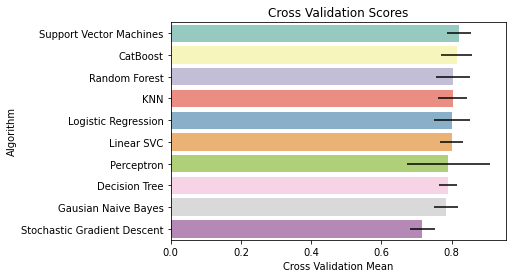

In [116]:
sns.barplot('Cross Validation Mean', 'Algorithm', data = cv_res, order = cv_res.sort_values(by = 'Cross Validation Mean', ascending = False)['Algorithm'], palette = 'Set3', **{'xerr': cv_std})
plt.ylabel('Algorithm')
plt.title('Cross Validation Scores')

As we can see, support vector machines has the highest cross validation mean and thus we will proceed with this model.

## 6.3.3 Hyperparameter tuning for SVM

Hyperparameter tuning is the process of tuning the parameters of a model. Here I will tune the parameters of support vector classifier using GridSearchCV.

In [117]:
param_grid = {'C': [0.1, 1, 10, 100, 1000],  
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
              'kernel': ['rbf']}  
  
grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3) 

grid.fit(X_train, Y_train) 

Fitting 3 folds for each of 25 candidates, totalling 75 fits
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV]  C=0.1, gamma=1, kernel=rbf, score=0.735593220338983, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV]  C=0.1, gamma=1, kernel=rbf, score=0.6860068259385665, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV]  C=0.1, gamma=1, kernel=rbf, score=0.6723549488054608, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV]  C=0.1, gamma=0.1, kernel=rbf, score=0.8033898305084746, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV]  C=0.1, gamma=0.1, kernel=rbf, score=0.7918088737201365, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV]  C=0.1, gamma=0.1, kernel=rbf, score=0.8054607508532423, total=   0.0s
[CV] C=0.1, gamma=0.01, kernel=rbf .............................

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[CV]  C=0.1, gamma=0.01, kernel=rbf, score=0.6143344709897611, total=   0.0s
[CV] C=0.1, gamma=0.001, kernel=rbf ..................................
[CV]  C=0.1, gamma=0.001, kernel=rbf, score=0.6135593220338983, total=   0.0s
[CV] C=0.1, gamma=0.001, kernel=rbf ..................................
[CV]  C=0.1, gamma=0.001, kernel=rbf, score=0.6143344709897611, total=   0.0s
[CV] C=0.1, gamma=0.001, kernel=rbf ..................................
[CV]  C=0.1, gamma=0.001, kernel=rbf, score=0.6143344709897611, total=   0.0s
[CV] C=0.1, gamma=0.0001, kernel=rbf .................................
[CV]  C=0.1, gamma=0.0001, kernel=rbf, score=0.6135593220338983, total=   0.0s
[CV] C=0.1, gamma=0.0001, kernel=rbf .................................
[CV]  C=0.1, gamma=0.0001, kernel=rbf, score=0.6143344709897611, total=   0.0s
[CV] C=0.1, gamma=0.0001, kernel=rbf .................................
[CV]  C=0.1, gamma=0.0001, kernel=rbf, score=0.6143344709897611, total=   0.0s
[CV] C=1, gamma=1, kernel=

[CV] ........ C=1000, gamma=0.01, kernel=rbf, score=0.8, total=   0.0s
[CV] C=1000, gamma=0.01, kernel=rbf ..................................
[CV]  C=1000, gamma=0.01, kernel=rbf, score=0.8327645051194539, total=   0.0s
[CV] C=1000, gamma=0.01, kernel=rbf ..................................
[CV]  C=1000, gamma=0.01, kernel=rbf, score=0.8293515358361775, total=   0.0s
[CV] C=1000, gamma=0.001, kernel=rbf .................................
[CV]  C=1000, gamma=0.001, kernel=rbf, score=0.7830508474576271, total=   0.0s
[CV] C=1000, gamma=0.001, kernel=rbf .................................
[CV]  C=1000, gamma=0.001, kernel=rbf, score=0.8054607508532423, total=   0.0s
[CV] C=1000, gamma=0.001, kernel=rbf .................................
[CV]  C=1000, gamma=0.001, kernel=rbf, score=0.7952218430034129, total=   0.0s
[CV] C=1000, gamma=0.0001, kernel=rbf ................................
[CV]  C=1000, gamma=0.0001, kernel=rbf, score=0.7830508474576271, total=   0.0s
[CV] C=1000, gamma=0.0001, ker

[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed:    1.7s finished


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [0.1, 1, 10, 100, 1000], 'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 'kernel': ['rbf']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=3)

In [118]:
print("Best parameters: ", grid.best_params_) 
print("Best estimator: ", grid.best_estimator_)

Best parameters:  {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
Best estimator:  SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


In [119]:
# Training accuracy

svc = SVC(C = 100, gamma = 0.01, kernel = 'rbf')
svc.fit(X_train, Y_train)
Y_pred = svc.predict(X_test)
acc_svc = round(svc.score(X_train, Y_train) * 100, 2)
acc_svc

83.54

In [120]:
# Mean cross validation score

cross_val_score(svc, X_train, Y_train, scoring = 'accuracy', cv = 10).mean()

0.8297242083758938

Our mean cross validation score improved slightly.

In [121]:
# Survival predictions by support vector classifier

Y_pred

array([0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1,
       0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [122]:
len(Y_pred)

418

# 7. Preparing data for submission

In [123]:
ss.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [124]:
ss.shape

(418, 2)

We want our submission dataframe to have 418 rows and 2 columns, PassengerId and Survived. 

In [125]:
# Create submission dataframe

submit = pd.DataFrame({'PassengerId': test['PassengerId'], 'Survived': Y_pred})
submit.head()

,PassengerId,Survived
881,892,0
882,893,0
883,894,0
884,895,0
885,896,1


In [ ]:
submit.shape

Our dataframe is ready for submission!

In [126]:
# Create and save csv file 

submit.to_csv("../data/final/mdp_titanic_submission_tutorial.csv", index = False)

# 8. Possible extensions to improve model accuracy

1. Analyse ticket and cabin features
    - Do these features help predict passenger survival?
    - If yes, consider including them in the training set instead of dropping
2. Come up with alternative features in feature engineering
    - Is there any other features you can potentially create from existing features in the dataset
3. Remove features that are less important
    - Does removing features help reduce overfitting in the model?
4. Ensemble modelling
    - This is a more advanced technique whereby you combine prediction results from multiple machine learning models

# 9. Conclusion

You should achieve a submission score of 0.77511 if you follow exactly what I have done in this notebook. In other words, I have correctly predicted 77.5% of the test set. I highly encourage you to work through this project again and see if you can improve on this result.

If you found any mistakes in the notebook or places where I can potentially improve on, feel free to reach out to me. Let's help each other get better - happy learning!

My platforms: 
- [Facebook](https://www.facebook.com/chongjason914)
- [Instagram](https://www.instagram.com/chongjason914)
- [Twitter](https://www.twitter.com/chongjason914)
- [LinkedIn](https://www.linkedin.com/in/chongjason914)
- [YouTube](https://www.youtube.com/channel/UCQXiCnjatxiAKgWjoUlM-Xg?view_as=subscriber)
- [Medium](https://www.medium.com/@chongjason)